# 1. Data understanding

In [722]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

df_2014 = pd.read_csv('2014.csv')
df_2016 = pd.read_csv('2016.csv')
df_2017 = pd.read_csv('2017.csv')
df_2018 = pd.read_csv('2018.csv')
df_2019 = pd.read_csv('2019.csv')
df_2020 = pd.read_csv('2020.csv')
df_2021 = pd.read_csv('2021.csv')
df_2022 = pd.read_csv('2022.csv')

shapes = []
missing = []
year = []
for y in range(2014, 2023):
    if y == 2015: continue
    df = "df_" + str(y)
    year.append(y)
    shapes.append(eval(df).shape)
    missing.append('{0:.2f}'.format(np.sum(eval(df).isna().sum().tolist()) / eval(df).size))
pd.DataFrame({'Year': year, 'Shapes': shapes, 'Missing data share': missing})


,Year,Shapes,Missing data share
0,2014,"(1260, 27)",0.06
1,2016,"(1433, 63)",0.24
2,2017,"(756, 123)",0.50
3,2018,"(417, 123)",0.50
4,2019,"(352, 82)",0.31
5,2020,"(180, 120)",0.53
6,2021,"(131, 124)",0.54
7,2022,"(164, 126)",0.54


# <span style="font-size:0.7em;">Note: Section 1.1 "Scope of the problem" in the report is done in notebook section 2.3 (below).</span> 

# 1.2. MHC types

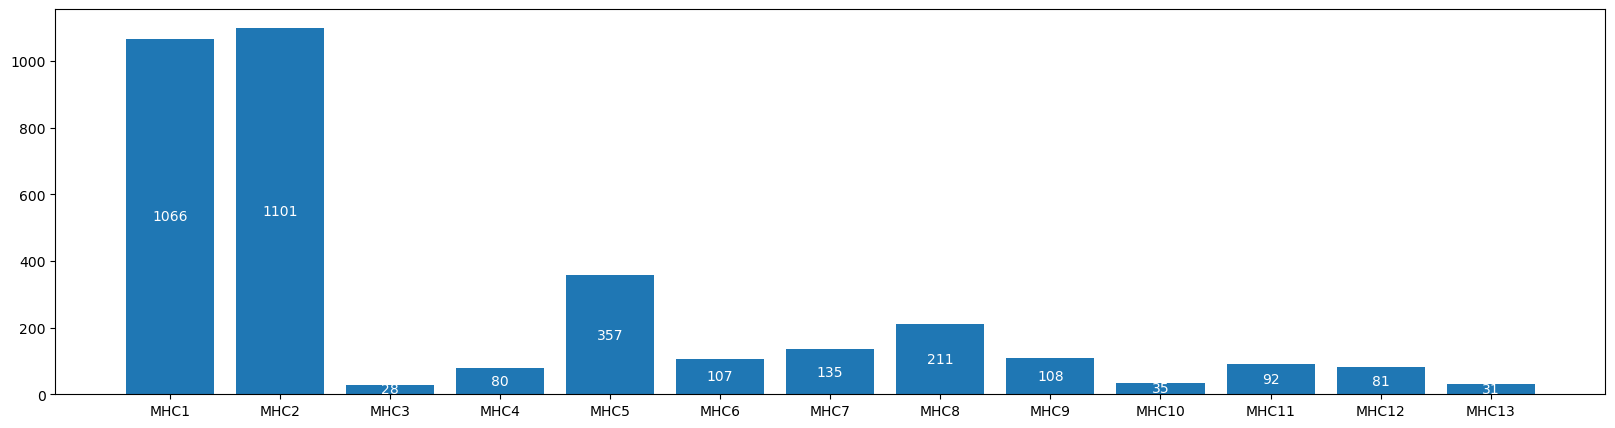

In [723]:
# Tranforming 2016 open question MHC types to 2017-2022 types

mhc_2016_dict =  {'ADD (w/o Hyperactivity)': 'MHC5',
                  'Addictive Disorder': 'MHC12',
                  'Anxiety Disorder (Generalized, Social, Phobia, etc)': 'MHC1',
                   'Asperges': 'MHC6',
                   'Attention Deficit Hyperactivity Disorder': 'MHC5',
                   'Autism': 'MHC6',
                   "Autism (Asperger's)": 'MHC6',
                   'Autism Spectrum Disorder': 'MHC6',
                   'Autism spectrum disorder': 'MHC6',
                   'Burn out': 'MHC9',
                   'Combination of physical impairment (strongly near-sighted) with a possibly mental one (MCD / "ADHD", though its actually a stimulus filtering impairment)': 'MHC1',
                   'Depression': 'MHC2',
                   'Dissociative Disorder': 'MHC10',
                   'Eating Disorder (Anorexia, Bulimia, etc)': 'MHC4',
                   'Gender Dysphoria': 'MHC13',
                    "I haven't been formally diagnosed, so I felt uncomfortable answering, but Social Anxiety and Depression.": np.nan,
                    'Intimate Disorder': 'MHC6',
                    'Mood Disorder (Depression, Bipolar Disorder, etc)': 'MHC2',
                    'Obsessive-Compulsive Disorder': 'MHC7',
                    'PDD-NOS': 'MHC13',
                    'PTSD (undiagnosed)': 'MHC8',
                    'Personality Disorder (Borderline, Antisocial, Paranoid, etc)': 'MHC6',
                     'Pervasive Developmental Disorder (Not Otherwise Specified)': 'MHC13',
                     'Post-traumatic Stress Disorder': 'MHC8',
                     'Psychotic Disorder (Schizophrenia, Schizoaffective, etc)': 'MHC3',
                     'Schizotypal Personality Disorder': 'MHC6',
                     'Seasonal Affective Disorder': 'MHC2',
                     'Sexual addiction': 'MHC12',
                     'Sleeping Disorder': 'MHC9',
                     'Stress Response Syndromes': 'MHC9',
                     'Substance Use Disorder': 'MHC11',
                     'Transgender': np.nan,             # not MHC
                     'Traumatic Brain Injury': np.nan   # not MHC
                 }

mhc_dict = {'MHC1': 'Anxiety Disorder (Generalized, Social, Phobia, etc)',
             'MHC2': 'Mood Disorder (Depression, Bipolar Disorder, etc)',
             'MHC3': 'Psychotic Disorder (Schizophrenia, Schizoaffective, etc)',
             'MHC4': 'Eating Disorder (Anorexia, Bulimia, etc)',
             'MHC5': 'Attention Deficit Hyperactivity Disorder',
             'MHC6': 'Personality Disorder (Borderline, Antisocial, Paranoid, etc)',
             'MHC7': 'Obsessive-Compulsive Disorder',
             'MHC8': 'Post-Traumatic Stress Disorder',
             'MHC9': 'Stress Response Syndromes',
             'MHC10': 'Dissociative Disorder',
             'MHC11': 'Substance Use Disorder',
             'MHC12': 'Addictive Disorder',
             'MHC13': 'Other'}

# We create 13 features: one fore each MHC type
# There is only one open question about MHC types in 2016
for index, row in df_2016.iterrows():
    if pd.isna(row['If yes, what condition(s) have you been diagnosed with?']):
        for key in mhc_dict.keys(): df_2016.at[index, key] = np.nan
    else:
        mhc_list = row['If yes, what condition(s) have you been diagnosed with?'].split("|")
        replace_list = [mhc_2016_dict.get(key, 'Unknown') for key in mhc_list]
        for key in mhc_dict.keys():
            if key in replace_list:
                df_2016.at[index, key] = 1              # MHC is present
            else: df_2016.at[index, key] = 0            # MHC is not present


# In 2019 there is also only one question for MHC types, but types options are fixed
for index, row in df_2019.iterrows():
    if pd.isna(row['*If so, what disorder(s) were you diagnosed with?*']):
        for key in mhc_dict.keys(): df_2019.at[index, key] = np.nan
    else:
        elem = row['*If so, what disorder(s) were you diagnosed with?*']
        elem = elem.replace('Post-traumatic Stress Disorder', 'Post-Traumatic Stress Disorder')
        for mhc in mhc_dict.values():
            i = elem.find(mhc)
            if i != -1:                                  # MHC found
                elem = elem[i + len(elem):]              # Reduce element on the found string
                key = next((k for k, v in mhc_dict.items() if v == mhc), None)  # Getting the key value like MHCn for the found value in elem 
                df_2019.at[index, key] = 1
        for k in mhc_dict.keys():
            try: 
                if pd.isna(df_2019.at[index, k]): df_2019.at[index, k] = 0
            except KeyError: df_2019.at[index, k] = 0 

# Filling in MHC types variables in 2017-2022 waves, except for 2019 
for y in range(2017, 2023):
    if y == 2019: continue
    df = "df_" + str(y)
    # Fixing mistake in columns naming 
    eval(df).rename(columns={'Post-traumatic Stress Disorder': 'Post-Traumatic Stress Disorder.1',
                             'Post-traumatic Stress Disorder.1': 'Post-Traumatic Stress Disorder.2'}, inplace=True)
    # Going row by row, checking 3 questions for each MHC type and filling new MHC features    
    for index, row in eval(df).iterrows():
        for key in mhc_dict.keys():
            if pd.isna(row[mhc_dict[key]]) and pd.isna(row[mhc_dict[key] + '.1']) and pd.isna(row[mhc_dict[key] + '.2']):
                eval(df).at[index, key] = 0                 # If all three MHC type variables are nan put into MHCn column zero
            else: eval(df).at[index, key] = 1               # If at least one variable is not nan -> put into MHCn column 1
        if eval(df).loc[index, 'MHC1':'MHC13'].sum() == 0: 
            eval(df).loc[index, 'MHC1':'MHC13'] = np.nan    # In case all MHCn's are zero -> replace zeros with nan

# Print bar chart for MHC types
ws = [0]*13
for y in range(2016, 2023):
    df = "df_" + str(y)
    ns = [eval(df)[x].sum() for x in mhc_dict.keys()]
    ws = [sum(x) for x in zip(ws, ns)]

plt.figure(figsize=(20,5))
p = plt.bar(mhc_dict.keys(), ws)
plt.bar_label(p, label_type='center', color='white')
plt.show()

# 2.1 Target variables (Section 2 "Data preparation" in the report)

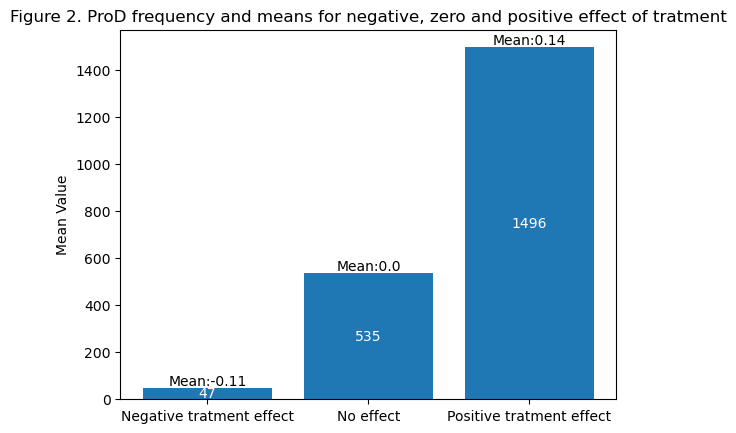

In [724]:
# We start with MHC tratment effect on productivity and begin collect total_df - final dataset 
# to be used for modeling

ques_dic = {'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': 'ProTE',
            'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': 'ProNTE',
            'If you have a mental health disorder, how often do you feel that it interferes with your work <strong>when being treated effectively?</strong>': 'ProTE',
            'If you have a mental health disorder, how often do you feel that it interferes with your work <strong>when <em>NOT</em> being treated effectively (i.e., when you are experiencing symptoms)?</strong>': 'ProNTE',
            'If you have a mental health disorder, how often do you feel that it interferes with your work *when being treated effectively?*': 'ProTE',
            'If you have a mental health disorder, how often do you feel that it interferes with your work *when* _*NOT*_* being treated effectively (i.e., when you are experiencing symptoms)?*': 'ProNTE',
            'If you have a mental health disorder, how often do you feel that it interferes with your work <strong>when</strong> <em><strong>NOT</strong></em><strong> being treated effectively (i.e., when you are experiencing symptoms)?</strong>': 'ProNTE'
           }

enc_dic = {'Never': 1, 'Rarely': 0.95, 'Sometimes': 0.9, 'Often': 0.75, 'Not applicable to me': np.nan}
col_list = ['ProTE', 'ProNTE', 'year']
total_df = pd.DataFrame(columns=col_list)
total_df['year'] = [2014] * 1260
total_df['ProTE'] = [np.nan] * 1260
total_df['ProNTE'] = [np.nan] * 1260

for y in range(2016, 2023):
    df = "df_" + str(y)
    eval(df)['year'] = y
    eval(df).rename(columns=ques_dic, inplace=True)
    # Concatenate Series from each wave into total_df
    total_df = pd.concat([total_df, eval(df)[col_list]], ignore_index=True)
for col in col_list: total_df[col].replace(enc_dic, inplace=True)   # Encode ordinal with numerical ones

# Creating first target variable ProD = difference of ProNTE and ProTE
total_df['ProD'] = total_df['ProTE'] - total_df['ProNTE'] 

# Let's make a bar chart for negative, zero and positive values of ProD
# Calculate mean values for negative, zero and positive values of ProD
means = [round(total_df[total_df['ProD']<0]['ProD'].mean(), 2),
         round(total_df[total_df['ProD']==0]['ProD'].mean(), 2),
         round(total_df[total_df['ProD']>0]['ProD'].mean(), 2)]

# Plotting the bar chart
fig, ax = plt.subplots()
bars = ax.bar(['Negative tratment effect', 'No effect', 'Positive tratment effect'],
            [total_df[total_df['ProD']<0]['ProD'].count(), 
             total_df[total_df['ProD']==0]['ProD'].count(), 
             total_df[total_df['ProD']>0]['ProD'].count()])
ax.bar_label(bars, label_type='center', color='white')
i = 0
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, 'Mean:' + str(means[i]), ha='center', va='bottom')
    i += 1
ax.set_ylabel('Mean Value')
ax.set_title('Figure 2. ProD frequency and means for negative, zero and positive effect of tratment')
plt.show()



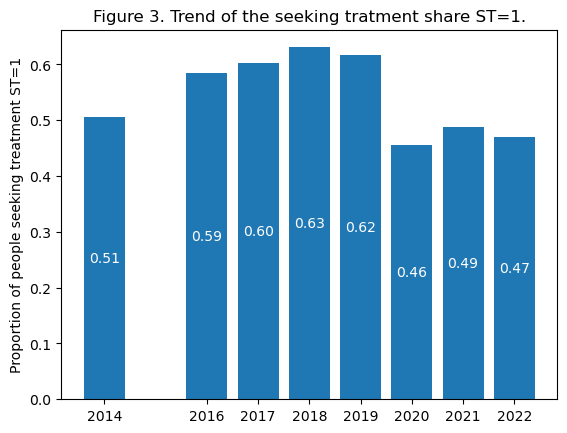

Chi-Square test if ST is independent from year
Chi-Square Statistic: 53.79988957942294
P-value: 2.5762716257143734e-09


In [725]:
# Second target variable ST - if the person sought treatment
ques_dic = {'Have you sought treatment for a mental health condition?': 'ST',                                      # 2014
            'Have you ever sought treatment for a mental health issue from a mental health professional?': 'ST',   # 2016
            'Have you ever sought treatment for a mental health disorder from a mental health professional?': 'ST' # 2017-2022
           }

enc_dic = {'Yes': 1, 'No': 0}
ts = pd.Series()
for y in range(2014, 2023):
    if y == 2015: continue
    df = "df_" + str(y)
    eval(df).rename(columns=ques_dic, inplace=True)
    # Concatenate Series from each wave into total_df
    ts = pd.concat([ts, eval(df)['ST']], ignore_index=True)
total_df['ST'] = ts
total_df['ST'].replace(enc_dic, inplace=True)   # Encode with numerical values

# Plotting the bar plot
years = total_df['ST'].groupby(total_df.year).value_counts(normalize=True).xs(1, level='ST').index
values = total_df['ST'].groupby(total_df.year).value_counts(normalize=True).xs(1, level='ST').values

# Plotting the bar chart
fig, ax = plt.subplots()
bars = ax.bar(years, values)
ax.set_xticks(years)
ax.set_xticklabels(years)
ax.bar_label(bars, labels=[f'{v:.2f}' for v in values], label_type='center', color='white')
ax.set_ylabel('Proportion of people seeking treatment ST=1')
ax.set_title('Figure 3. Trend of the seeking tratment share ST=1.')
plt.show()

# Chi-Square test if ST is independent from year
contingency_table = pd.crosstab(total_df['year'], total_df['ST'])
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print('Chi-Square test if ST is independent from year')
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p_value}")

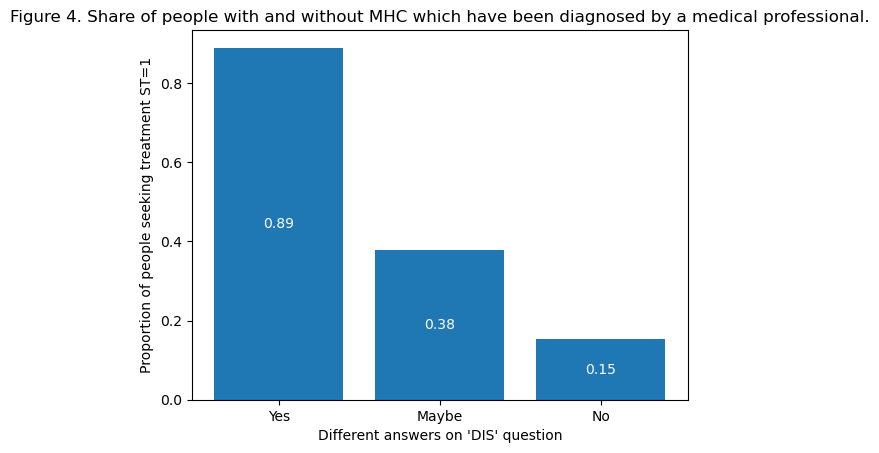

In [726]:
# MHCA - if the person has MHC and 
# MHCD if a person has MHC with official diagnosis (1 if yes, 0 if no)

ques_dic = {'Do you currently have a mental health disorder?': 'DIS',
            'Do you *currently* have a mental health disorder?': 'DIS'
           }

ts = pd.Series([np.nan] * 1260) 
for y in range(2016, 2023):
    df = "df_" + str(y)
    eval(df).rename(columns=ques_dic, inplace=True)
    ts = pd.concat([ts, eval(df)['DIS']], ignore_index=True)

def encoder(dis):
    if pd.isna(dis): return np.nan
    elif dis == 'Yes': return 1
    elif dis in ['Maybe', 'Possibly']: return 0
    else: return np.nan

def encoder2(dis):
    if pd.isna(dis): return np.nan
    elif dis in ['Yes', 'Maybe', 'Possibly']: return 1
    elif dis == 'No': return 0
    else: return np.nan

total_df['MHCD'] = ts.apply(encoder)
total_df['MHCA'] = ts.apply(encoder2)

# Checking share of people having MHC with diagnosis in 2016
diag = 'Have you been diagnosed with a mental health condition by a medical professional?'
values = [df_2016[df_2016.DIS == 'Yes'][diag].value_counts(normalize=True).sort_index()[1],
          df_2016[df_2016.DIS == 'Maybe'][diag].value_counts(normalize=True).sort_index()[1],
          df_2016[df_2016.DIS == 'No'][diag].value_counts(normalize=True).sort_index()[1]]

# Plotting the bar chart
fig, ax = plt.subplots()
bars = ax.bar(['Yes', 'Maybe', 'No'], values)
ax.bar_label(bars, labels=[f'{v:.2f}' for v in values], label_type='center', color='white')
ax.set_ylabel('Proportion of people seeking treatment ST=1')
ax.set_xlabel("Different answers on 'DIS' question")
ax.set_title('Figure 4. Share of people with and without MHC which have been diagnosed by a medical professional.')
plt.show()

# 2.2 Features

# <span style="font-size:0.7em;">2.2.1. Demographics</span>  

In [727]:
# Shere of people working and living in different countries is very small
print('Table 4. Shere of people working and living in different countries.')
shares = []
year = []
for y in range(2016, 2023):
    df = "df_" + str(y)
    year.append(y)
    a = {}
    for col in eval(df).columns:
        if 'country' in str.lower(col):
            if len(a) == 0: 
                a = pd.DataFrame(eval(df)[col].value_counts())
            else: 
                b = pd.DataFrame(eval(df)[col].value_counts())
                c = a.join(b, how='left', rsuffix='_work', lsuffix='_live')
                # Count people with not the same work and live country, divide by two to avoid double counting
                c['diff'] = np.abs(c.count_live - c.count_work) / 2          
                shares.append('{0:.3f}'.format(c['diff'].sum() / c.count_live.sum()))

pd.DataFrame({'Year': year, 'Shares': shares})

Table 4. Shere of people working and living in different countries.


,Year,Shares
0,2016,0.010
1,2017,0.012
2,2018,0.011
3,2019,0.003
4,2020,0.008
5,2021,0.015
6,2022,0.015


In [728]:
# Additing country CTRY to total_df
ques_dic = {'Country': 'CTRY',
            'What country do you live in?': 'CTRY',
            'What country do you *live* in?': 'CTRY',
            'What country do you <strong>live</strong> in?': 'CTRY'}

ts = pd.Series()
for y in range(2014, 2023):
    if y == 2015: continue
    df = "df_" + str(y)
    eval(df).rename(columns=ques_dic, inplace=True)
    ts = pd.concat([ts, eval(df)['CTRY']], ignore_index=True)

ts.fillna('United States', inplace=True)      # Fill nan country (2 samples) with the most frequent value - United States
ts.replace({'United States of America': 'United States'}, inplace=True)
ts = ts.apply(lambda x: 'Other' if x not in ['United States', 'United Kingdom', 'Canada', 'Germany'] else x)
total_df['CTRY'] = ts
total_df['CTRY'].value_counts(normalize=True)

CTRY
United States     0.593224
Other             0.218197
United Kingdom    0.107820
Canada            0.047731
Germany           0.033028
Name: proportion, dtype: float64

In [729]:
df_2017['What is your race?'].value_counts(normalize=True)

What is your race?
White                         0.902490
More than one of the above    0.029046
I prefer not to answer        0.029046
Asian                         0.026971
Black or African American     0.012448
Name: proportion, dtype: float64

Missing: 22
Age median: 33.0


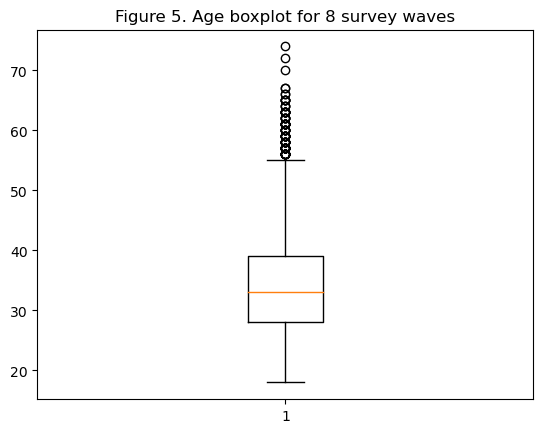

In [730]:
#Checking age 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

age = pd.Series()
for y in range(2014, 2023):
    if y == 2015: continue
    df = "df_" + str(y)
    for col in eval(df).columns:
        if col == 'Age' or col == 'What is your age?':
            age = pd.concat([age, eval(df)[col]], ignore_index=True)

age = age.apply(lambda x: np.nan if x > 75 else x)
age = age.apply(lambda x: np.nan if x < 18 else x)
print('Missing:', age.isna().sum())
age.fillna(value=age.median(), inplace=True)
total_df['Age'] = age
print('Age median:', age.median())

plt.boxplot(age)
plt.title('Figure 5. Age boxplot for 8 survey waves')
plt.show()

Number of unique genders: 70


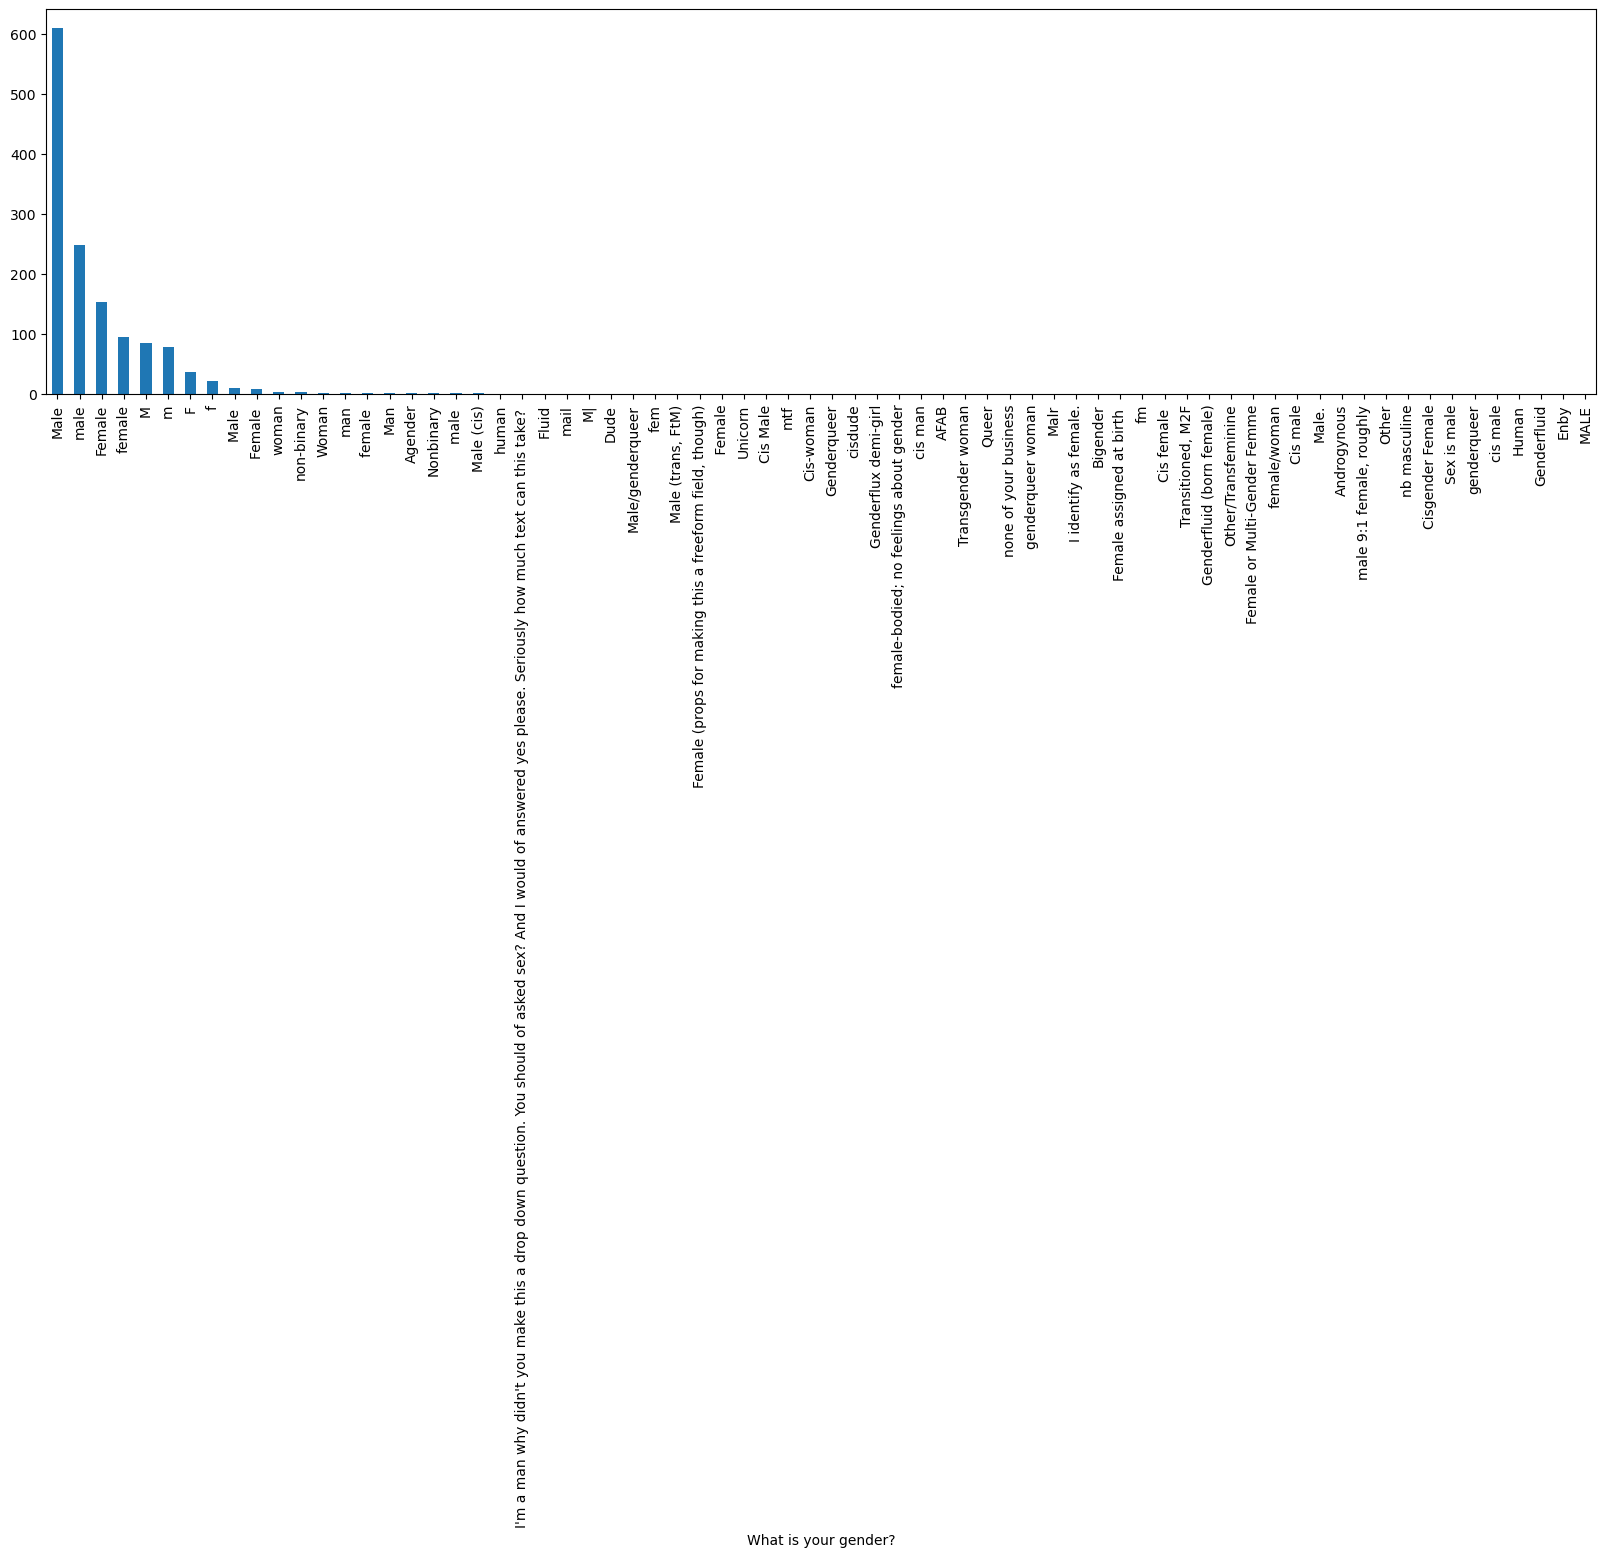

In [731]:
# Gender if messy in 2016
plt.figure(figsize=(20,5))
df_2016['What is your gender?'].value_counts().plot(kind='bar', color = 'C0')
print('Number of unique genders:', len(df_2016['What is your gender?'].value_counts().tolist()))

In [732]:
# Cleaning Gender variable in all waves
male_list = ['M', 'Male', 'male', 'm', 'Male-ish', 'maile', 'Cis Male', 'Mal', 'Male (CIS)', 'Make', 'Guy (-ish) ^_^',
            'Male ', 'Man', 'msle', 'Female (trans)', 'Mail', 'cis male', 'Malr', 'Cis Man', 'man', 'Cis male', 'Male.', 
            'Male (cis)', 'Sex is male', 'Dude', "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
            'mail', 'M|', 'male ', 'cisdude', 'cis man', 'MALE', 'cis-male', 'cis hetero male', "male (hey this is the tech industry you're talking about)",
            'Cis-male', 'Male, cis', 'cis male ', 'dude', 'male, born with xy chromosoms', 'Malel', 'Cisgender male', 'Masculine', 'I have a penis',
            'masculino', 'CIS Male', 'mostly male', 'cisgender male', 'MAle', 'male/he/him', 'homem cis', 'cis-het male', 'varón']
female_list = ['Female', 'female', 'Cis Female', 'F', 'Woman', 'f', 'Femake', 'woman', 'Female ', 'cis-female/femme', 'Female (cis)', 'femail',
              'female ', 'Female assigned at birth ', 'fm', 'Cis female ', 'female/woman', 'Cisgender Female', 'fem', 
              'Female (props for making this a freeform field, though)', ' Female', 'Cis-woman', 'femalw', 'female (cis)', 'My sex is female.',
              'female (cisgender)', 'Female (cis) ', 'cis-Female', 'cis female', 'F, cisgender', '*shrug emoji* (F)', 'Cis woman', 
              'Female (cisgender)', 'Cis-Female', 'Cisgendered woman', 'cisgender female', 'cis woman', 'femmina', 'Femile', 'FEMALE', 'female, she/her',
              'Female, cis-gendered']

gender = pd.Series()
for y in range(2014, 2023):
    if y == 2015: continue
    df = "df_" + str(y)
    for col in eval(df).columns:
        if col == 'Gender' or col == 'What is your gender?':
            gender = pd.concat([gender, eval(df)[col]], ignore_index=True)
   
gender = gender.replace(male_list, 'Male')
gender = gender.replace(female_list, 'Female')
print("Value counts of Gender before filling nan's:")
print(gender.value_counts(normalize=True))

# Replace nan's (34 observations) randomly
categories = ['Male', 'Female', 'Other']
probabilities = [0.715534, 0.251012, 1 - 0.715534 - 0.251012]
gender = gender.apply(lambda x: np.random.choice(categories, p=probabilities) if pd.isna(x) else x)
gender = gender.apply(lambda x: 'Other' if x not in ['Male', 'Female', 'Other'] else x)
print('')
print("Value counts of Gender after filling nan's:")
print(gender.value_counts())
total_df['Gender'] = gender


Value counts of Gender before filling nan's:
Male                     0.720756
Female                   0.252844
Nonbinary                0.001717
non-binary               0.001502
Agender                  0.000859
                           ...   
Human                    0.000215
genderqueer              0.000215
none of your business    0.000215
nb masculine             0.000215
Non-binary/Agender       0.000215
Name: proportion, Length: 94, dtype: float64

Value counts of Gender after filling nan's:
Male      3380
Female    1188
Other      125
Name: count, dtype: int64


# <span style="font-size:0.7em;">2.2.2. Employer MHC friendliness features</span>  

Missing values:
INT1_1     586
INT1_2     586
INT2_1    1752
INT3_1     586
INT3_2    1578
INT3_3     586
INT3_4     586
INT1_4       0
dtype: int64 4693

Missing values after droping lives with all nan's:
INT1_1       0
INT1_2       0
INT2_1    1166
INT3_1       0
INT3_2     992
INT3_3       0
INT3_4       0
INT1_4       0
dtype: int64 4107



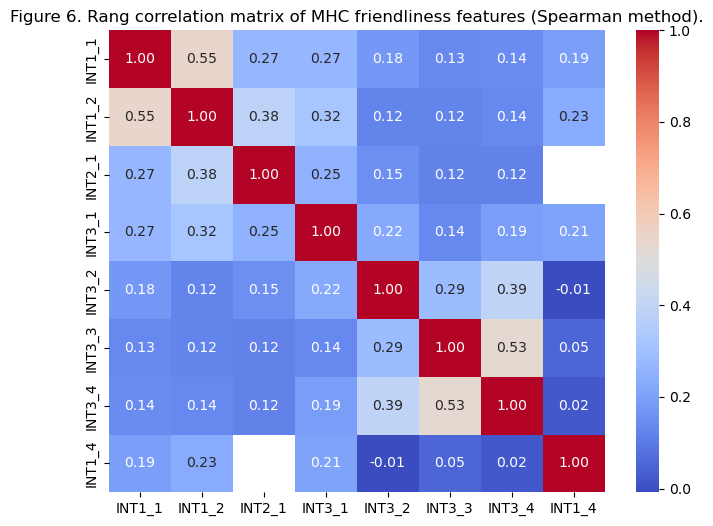

In [733]:
# Assemblying intervention features

ques_dic = {'---2014--------------------------------------------------------------------------------------------------': 0,
            'Has your employer ever discussed mental health as part of an employee wellness program?': 'INT1_1',
            'Does your employer provide resources to learn more about mental health issues and how to seek help?': 'INT1_2',
            'Do you know the options for mental health care your employer provides?': 'INT1_3',
            'Does your employer provide mental health benefits?': 'INT2_1',
            'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?': 'INT3_1',
            'How easy is it for you to take medical leave for a mental health condition?': 'INT3_2',
            'Would you be willing to discuss a mental health issue with your coworkers?': 'INT3_3',
            'Would you be willing to discuss a mental health issue with your direct supervisor(s)?': 'INT3_4',
            '----2016---------------------------------------------------------------------------------------------------': 0,
            'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'INT1_1',
            'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'INT1_2',
            'Do you know the options for mental health care available under your employer-provided coverage?': 'INT1_3',
            'Does your employer provide mental health benefits as part of healthcare coverage?': 'INT2_1',            
            'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'INT3_1',
            'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'INT3_2',
            'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'INT3_3',
            'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'INT3_4',
            '----2017-2022------------------------------------------------------------------------------------------------': 0,
            'Does your employer offer resources to learn more about mental health disorders and options for seeking help?': 'INT1_2',
            'Do you know the options for mental health care available under your employer-provided health coverage?': 'INT1_3',
            'Does your employer provide mental health benefits\xa0as part of healthcare coverage?': 'INT2_1',
            'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?': 'INT3_2',
            'Would you feel comfortable discussing a mental health issue with your coworkers?': 'INT3_3',
            'Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?': 'INT3_4'
           }

enc_dic_1 =  {'No': False, 'Yes': True, "Don't know": False, "I don't know": False}                                             #INT1 and 3_1
enc_dic_2 =  { 'No': False, 'Yes': True, "Don't know": np.nan, "I don't know": np.nan,
             'Not eligible for coverage / N/A': False, 'Not eligible for coverage / NA': False                                   #INT2
             }                                
enc_dic_3_2 = {'Very difficult': 0, 'Difficult': 1/6, 'Somewhat difficult': 1/3, 'Neither easy nor difficult': 1/2, 
             'Somewhat easy': 3/4, 'Very easy': 1, "I don't know": np.nan, "Don't know" : np.nan                                 #INT3_2
            }
enc_dic_3_3 = {'No': 0, 'Yes': 1, "Maybe": 0.5, "Some of them": 0.25}                                                             #NT3_3, 3_4                                                                                #NT3_3, 3_4 

#, 'Not sure': False, 'I am not sure': Fals

# Raplacing column names
new_cols = ['INT1_1', 'INT1_2', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4']
wdf = pd.DataFrame(columns=new_cols)
for y in range(2014, 2023):
    if y == 2015: continue
    df = "df_" + str(y)
    eval(df).rename(columns=ques_dic, inplace=True)
    wdf = pd.concat([wdf, eval(df)[new_cols]], ignore_index=True)


# Encoding
for col in new_cols:                                    
    if col == 'INT2_1':
        wdf[col].replace(enc_dic_2, inplace=True)
    elif col == 'INT3_2':
        wdf[col].replace(enc_dic_3_2, inplace=True)
    if col in ['INT3_3', 'INT3_4']:
        wdf[col].replace(enc_dic_3_3, inplace=True)                                       # Fill with numerical values
    else:
        wdf[col].replace(enc_dic_1, inplace=True)                                         # Fill INT1 and 3_1 with bool values

# Creating new information variable based on INT2_1 Don't know answer
wdf['INT1_4'] = wdf['INT2_1'].apply(lambda x: True if x in [True, False] else False)

# Checking number of nan's
print('Missing values:')
print(wdf.isna().sum(), wdf.shape[0])

# Dropping rows with all nan's
for index, row in wdf.iterrows():
    if row.isna().sum() > 6: wdf.drop(index, inplace=True)
print('')
print("Missing values after droping lives with all nan's:")
print(wdf.isna().sum(), wdf.shape[0])
print('')

# Print correlation matrix
correlation_matrix = wdf.corr(method='spearman')
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Figure 6. Rang correlation matrix of MHC friendliness features (Spearman method).')
plt.show()


In [734]:
# Replacing missing with linear regrssion predictions for INT3_2
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LinearRegression
import statsmodels.tools.tools as sm

cols = ['INT1_1', 'INT1_2', 'INT3_1', 'INT3_3', 'INT3_4']
X = wdf[~pd.isna(wdf['INT3_2'])][cols]
X_train = sm.add_constant(X)
y = wdf[~pd.isna(wdf['INT3_2'])].INT3_2
nan_indices = wdf[wdf['INT3_2'].isna()].index

# Using EFS for choosing best features for linera regression of INT2_1 on othe INT's
model = LinearRegression()
efs = EFS(estimator=model,       
         min_features=1,     
         max_features=5,     
         scoring='neg_mean_squared_error', 
         cv=4)

efs = efs.fit(X_train, y)
print('Best features combination:', efs.best_feature_names_)

# Get predicitons and replace nan's in INT3_2
X_train_best = X_train[list(efs.best_feature_names_)]
model.fit(X_train_best, y)
X_pred = wdf[pd.isna(wdf['INT3_2'])][list(efs.best_feature_names_)]
y_pred = model.predict(X_pred)
wdf.loc[nan_indices, 'INT3_2'] = y_pred
wdf.INT3_2.describe()

Features: 62/62

Best features combination: ('INT1_1', 'INT3_1', 'INT3_3', 'INT3_4')


count    4107.000000
mean        0.614712
std         0.277017
min         0.000000
25%         0.421928
50%         0.667395
75%         0.750000
max         1.000000
Name: INT3_2, dtype: float64

In [735]:
# Replacing missing with logit regrssion predictions for INT2_1
from sklearn.linear_model import LogisticRegression

cols = ['INT1_1', 'INT1_2', 'INT3_1', 'INT3_3', 'INT3_4']
X = wdf[~pd.isna(wdf['INT2_1'])][cols]
X_train = sm.add_constant(X)
y = wdf[~pd.isna(wdf['INT2_1'])].INT2_1.astype(int)
nan_indices = wdf[wdf['INT2_1'].isna()].index

# Using EFS for choosing best features for linera regression of INT2_1 on othe INT's
model = LogisticRegression()
efs = EFS(estimator=model,       
         min_features=1,     
         max_features=5,     
         scoring='accuracy', 
         cv=4)

efs = efs.fit(X_train, y)
print('Best features combination:', efs.best_feature_names_)

# Get predicitons and replace nan's in INT3_2
X_train_best = X_train[list(efs.best_feature_names_)]
model.fit(X_train_best, y)
X_pred = wdf[pd.isna(wdf['INT2_1'])][list(efs.best_feature_names_)]
y_pred = model.predict(X_pred)
wdf.loc[nan_indices, 'INT2_1'] = y_pred
wdf['INT2_1'] = wdf.INT2_1.astype(bool)
# Check that there is no nan's in wdf
print(wdf.isna().sum(), wdf.shape[0])

Features: 62/62

Best features combination: ('INT1_1', 'INT1_2', 'INT3_1')
INT1_1    0
INT1_2    0
INT2_1    0
INT3_1    0
INT3_2    0
INT3_3    0
INT3_4    0
INT1_4    0
dtype: int64 4107


In [736]:
total_df = total_df.join(wdf)
print(total_df.isna().sum(), total_df.shape[0])

ProTE     2569
ProNTE    2396
year         0
ProD      2615
ST           0
MHCD      2596
MHCA      1445
CTRY         0
Age          0
Gender       0
INT1_1     586
INT1_2     586
INT2_1     586
INT3_1     586
INT3_2     586
INT3_3     586
INT3_4     586
INT1_4     586
dtype: int64 4693


Cummulative variance by component: [0.33657333 0.53405914 0.64495876]


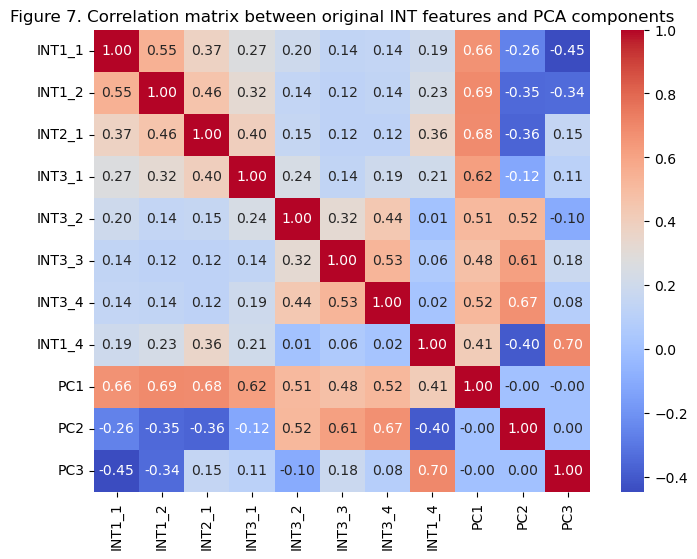

In [737]:
# PCA analysis for INT features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_standardized = scaler.fit_transform(wdf)        # Standartization -> mean =0, std = 1
df_standardized = pd.DataFrame(df_standardized, columns=wdf.columns)

pca = PCA(n_components=3)                             
pca_transformed = pca.fit_transform(df_standardized)
pca_df = pd.DataFrame(pca_transformed, columns=['PC1', 'PC2', 'PC3'])
combined_df = pd.concat([df_standardized, pca_df], axis=1)

var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print('Cummulative variance by component:', cum_var_exp)

# Compute the correlation matrix and plot the heatmap of the correlation matrix
correlation_matrix = combined_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Figure 7. Correlation matrix between original INT features and PCA components')
plt.show()

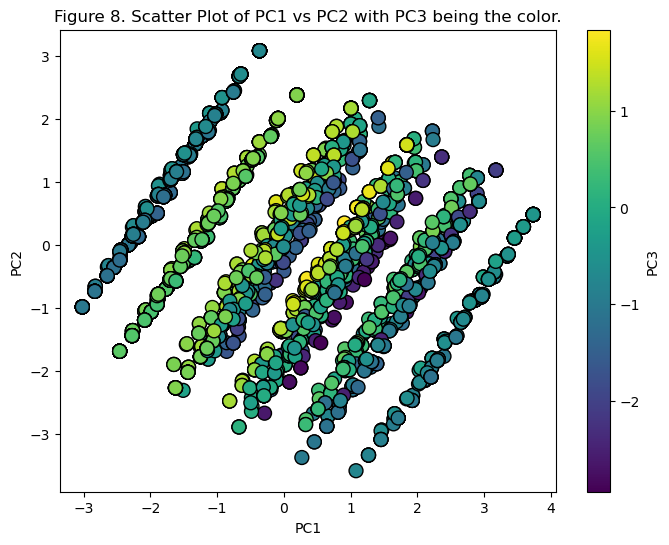

In [738]:
# Plot the scatter plot with MDS1, MDS2, and color representing MDS3
plt.figure(figsize=(8, 6))
scatter = plt.scatter(combined_df['PC1'], combined_df['PC2'], c=combined_df['PC3'], cmap='viridis', s=100, edgecolor='k') 
# Add a color bar
plt.colorbar(scatter, label='PC3')
# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Figure 8. Scatter Plot of PC1 vs PC2 with PC3 being the color.')

plt.show()

In [739]:
# Let's try MDS
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

original_distances = euclidean_distances(wdf)

mds = MDS(n_components=2, random_state=42)
mds_transformed = mds.fit_transform(wdf)
mds_distances = euclidean_distances(mds_transformed)

Explained Variation: 0.9690847053202869


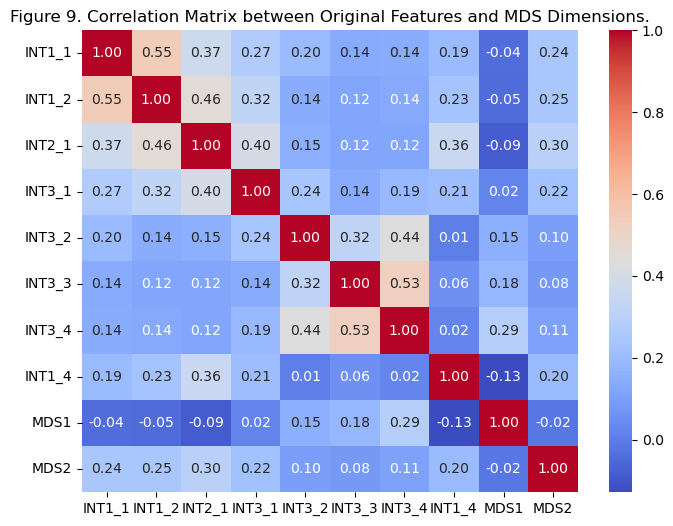

In [740]:
# Calulate explained variation:
stress = mds.stress_
explained_variation = 1 - (stress / np.sum(original_distances**2))
print(f"Explained Variation: {explained_variation}")

# Create a DataFrame for the MDS output
mds_df = pd.DataFrame(mds_transformed, columns=['MDS1', 'MDS2'])
combined_df = pd.concat([wdf, mds_df], axis=1)

# Compute the and plot correlation matrix
correlation_matrix = combined_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Figure 9. Correlation Matrix between Original Features and MDS Dimensions.')
plt.show()

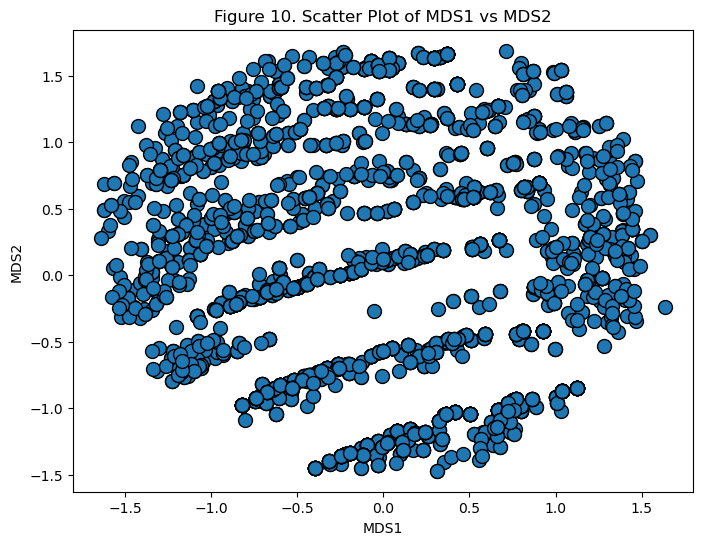

In [741]:
# Plot the scatter plot with MDS1, MDS2, and color representing MDS3
plt.figure(figsize=(8, 6))
scatter = plt.scatter(mds_df['MDS1'], mds_df['MDS2'], s=100, edgecolor='k')

# Add labels and title
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('Figure 10. Scatter Plot of MDS1 vs MDS2')

plt.show()

In [742]:
# Let's try DBSCAN to find some clusters
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_standardized = scaler.fit_transform(wdf)

# Apply DBSCAN
dbscan = DBSCAN(eps=2, min_samples=200)  # You might need to adjust these parameters
clusters = dbscan.fit_predict(df_standardized)

# Add the cluster labels to the original DataFrame
wdf['Cluster'] = clusters

# Check the unique clusters
print("Number of clusters found:", len(set(clusters)) - (1 if -1 in clusters else 0))  # -1 is the noise/outliers
wdf.Cluster.value_counts(normalize=True)

Number of clusters found: 5


Cluster
-1    0.341125
 0    0.209155
 1    0.173850
 2    0.138300
 3    0.084003
 4    0.053567
Name: proportion, dtype: float64

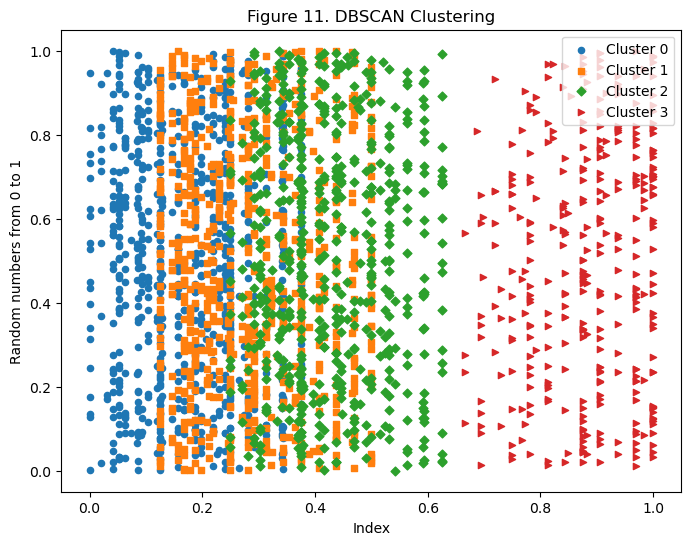

In [743]:
# Creating MHC friendliness index
wdf['Index'] = (wdf.INT1_1 + wdf.INT1_2 + wdf.INT1_4 + wdf.INT2_1 + wdf.INT3_1 + wdf.INT3_2 + wdf.INT3_3 + wdf.INT3_4)/8 

# Define marker styles for each cluster
marker_dict = {0:'o', 1:'s', 2:'D', 3:'>', 4:'<'}  # Different shapes (circles, squares, diamonds, etc.)

# Plot each cluster with a different marker
plt.figure(figsize=(8, 6))
clus = [0,1,2,3]
for cluster in clus:
    cluster_data = wdf[wdf['Cluster'] == cluster]
    random = np.random.rand(cluster_data.shape[0])
    scatter = plt.scatter(
                cluster_data['Index'], random,
                label=f'Cluster {cluster}', 
                marker=marker_dict[cluster], 
                s=20
                )

plt.title('Figure 11. DBSCAN Clustering')
plt.xlabel('Index')
plt.ylabel('Random numbers from 0 to 1')
plt.legend()
plt.show()


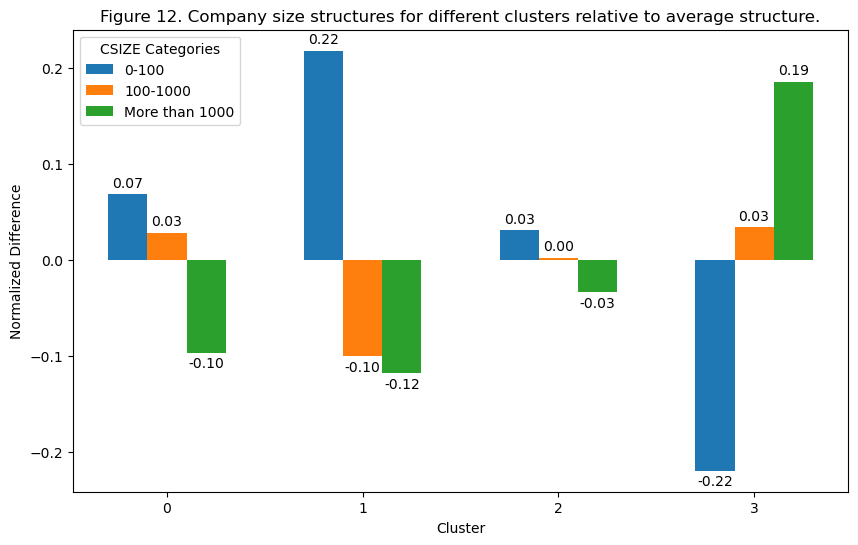

In [744]:
# Checking if cluters contain companies of different size

# Obtaining company size from 2016-2022 waves
ts = pd.Series([np.nan]*1260)
for y in range(2016, 2023):
    df = "df_" + str(y)
    eval(df).rename(columns={'How many employees does your company or organization have?': 'CSIZE'}, inplace=True)
    ts = pd.concat([ts, eval(df).CSIZE], ignore_index=True)
wdf['CSIZE'] = ts

# Decrease the number of sizes
def resize(size):
    if pd.isna(size): return np.nan
    elif size in ['1-5', '6-25', '26-100']: return '0-100'
    elif size in ['100-500', '500-1000']: return '100-1000'
    else: return 'More than 1000'

wdf['CSIZE'] = wdf['CSIZE'].apply(resize)
csize_categories = ['0-100', '100-1000', 'More than 1000']

tdf = pd.DataFrame(index=clus)
for cluster in clus:
    freq_dif = wdf[wdf.Cluster == cluster].CSIZE.value_counts(normalize=True) - wdf.CSIZE.value_counts(normalize=True)
    for csize in csize_categories:
        tdf.at[cluster, csize] = freq_dif.xs(csize)

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define the positions of the bars
bar_width = 0.2
positions = np.arange(len(clus))

# Plot each category and add labels
bars = []
for i, category in enumerate(csize_categories):
    bar = ax.bar(positions + i * bar_width, tdf[category], width=bar_width, label=category)
    bars.append(bar)
    # Adding labels to each bar
    ax.bar_label(bar, labels=[f'{v:.2f}' for v in tdf[category]], padding=3, fontsize=10)

# Add labels, title, and legend
ax.set_xlabel('Cluster')
ax.set_ylabel('Normalized Difference')
ax.set_title('Figure 12. Company size structures for different clusters relative to average structure.')
ax.set_xticks(positions + bar_width)  # Adjust x-ticks to align with clusters
ax.set_xticklabels(clus)
ax.legend(title='CSIZE Categories')

plt.show()




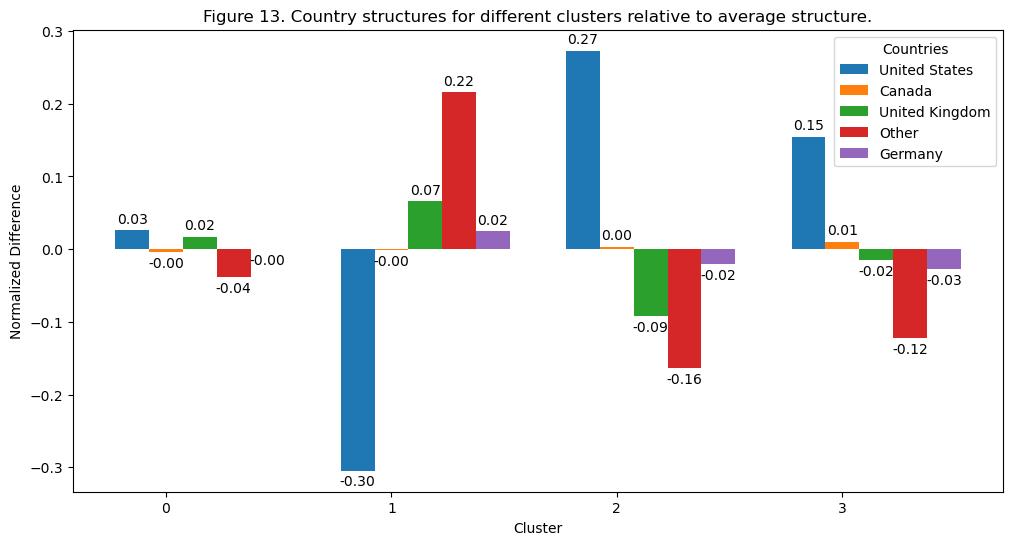

In [745]:
tds = total_df.join(wdf.Cluster)
tdf = pd.DataFrame(index=clus)
for cluster in clus:
    freq_dif = tds[tds.Cluster == cluster].CTRY.value_counts(normalize=True) - tds.CTRY.value_counts(normalize=True)
    for ctry in tds.CTRY.unique():
        tdf.at[cluster, ctry] = freq_dif.xs(ctry)

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Define the positions of the bars
bar_width = 0.15
positions = np.arange(len(clus))

# Plot each category and add labels
bars = []
for i, category in enumerate(tds.CTRY.unique()):
    bar = ax.bar(positions + i * bar_width, tdf[category], width=bar_width, label=category)
    bars.append(bar)
    # Adding labels to each bar
    ax.bar_label(bar, labels=[f'{v:.2f}' for v in tdf[category]], padding=3, fontsize=10)

# Add labels, title, and legend
ax.set_xlabel('Cluster')
ax.set_ylabel('Normalized Difference')
ax.set_title('Figure 13. Country structures for different clusters relative to average structure.')
ax.set_xticks(positions + bar_width)  # Adjust x-ticks to align with clusters
ax.set_xticklabels(clus)
ax.legend(title='Countries')

plt.show()

# <span style="font-size:0.7em;">2.3 Section "Introduction" in the report</span>  

In [746]:
# First we add Index column to total_df
total_df = total_df.join(wdf.Index)

In [747]:
# Now we have all variables needed to make scope of the problme calculations
# In 2016-2022 waves 40% of people who answered a question 'Do you currently have a mental health disorder?' (or similar), answered ‘Yes’
# and another 26% ‘Maybe’ (or similar)
print(df_2016.DIS.value_counts(normalize=True))

# If we encode ProNTE (and ProTE) as [0.75, 0.9, 0.95, 1] we get average ProNTE in our dataset for people with diagnosis 0.79, 
# which is 21% productivity loss. Treated MHC, according to this dataset, leads to a 9% reduction in productivity on average.
print('')
print('Average productivity of people with untreated diagnosed MHC:', total_df[total_df.MHCD == 1].ProNTE.mean()) 
print('')
print('Average productivity of people with treated diagnosed MHC:', total_df[total_df.MHCD == 1].ProTE.mean())

# For people without diagnosis average productivity loss is 16% if untreated and 9% if treated, 
# hence productivity gain from treatment is lower - only 7%.
print('')
print('Average productivity of people with untreated not diagnosed MHC:', total_df[total_df.MHCD == 0].ProNTE.mean()) 
print('')
print('Average productivity of people with treated not diagnosed MHC:', total_df[total_df.MHCD == 0].ProTE.mean())



DIS
Yes      0.401256
No       0.370551
Maybe    0.228193
Name: proportion, dtype: float64

Average productivity of people with untreated diagnosed MHC: 0.793036109064112

Average productivity of people with treated diagnosed MHC: 0.9098788796366389

Average productivity of people with untreated not diagnosed MHC: 0.8423333333333333

Average productivity of people with treated not diagnosed MHC: 0.9132415254237287


In [748]:
# To see how MHC friendliness imapct people willingness to seek tratment
from scipy.stats import ttest_ind

tdf = total_df[['Index', 'MHCD', 'ST']].copy()

BM1 = (tdf['MHCD'] == 1) & (tdf.Index < 0.25)
BM2 = (tdf['MHCD'] == 1) & (tdf.Index > 0.75)
BM3 = (tdf['MHCD'] == 0) & (tdf.Index < 0.25)
BM4 = (tdf['MHCD'] == 0) & (tdf.Index > 0.75)

a1 = tdf[BM1].ST.astype(int)
a2 = tdf[BM2].ST.astype(int)

b1 = tdf[BM3].ST.dropna().astype(int)
b2 = tdf[BM4].ST.dropna().astype(int)

print('People with diag seeking Treatment in MHC not friendly companies:', a1.mean(), a1.shape)
print('People with diag seeking Treatment in MHC friendly companies:', a2.mean(), a2.shape)

print('People with no diag seeking Treatment in MHC not friendly companies:', b1.mean(), b1.shape)
print('People with no diag seeking Treatment in MHC friendly companies:', b2.mean(), b2.shape)

# Welch's t-test 
t_stat, p_value = ttest_ind(a1,a2, equal_var=False)
print(f"T-statistic for DIAG people: {t_stat}")
print(f"P-value: {p_value}")

t_stat, p_value = ttest_ind(b1,b2, equal_var=False)
print(f"T-statistic for no DIAG people: {t_stat}")
print(f"P-value: {p_value}")

People with diag seeking Treatment in MHC not friendly companies: 0.8895348837209303 (172,)
People with diag seeking Treatment in MHC friendly companies: 0.9757281553398058 (206,)
People with no diag seeking Treatment in MHC not friendly companies: 0.39072847682119205 (151,)
People with no diag seeking Treatment in MHC friendly companies: 0.7101449275362319 (69,)
T-statistic for DIAG people: -3.2809404152480077
P-value: 0.00118931249128272
T-statistic for no DIAG people: -4.702331890872821
P-value: 6.078971810680877e-06


# 3.1. Modeing MHCA and MHCD.

In [749]:
# Checking independence of MHCA and MHCD from our features.

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

wdf = total_df.copy()
wdf = wdf.join(pd.get_dummies(total_df[['CTRY', 'Gender']], drop_first=True))
wdf.drop(columns=['Gender', 'CTRY', 'ProTE', 'ProNTE', 'year', 'ProD', 'ST', 'MHCD', 'Index'], inplace=True)
wdf.drop(columns=['INT1_1', 'INT1_2', 'INT1_4', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4'], inplace=True)
wdf = wdf.dropna()

X = wdf.drop(columns=['MHCA'])
y = wdf['MHCA']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Select the best features
selector = SelectKBest(chi2, k=2)
X_new = selector.fit_transform(X, y)

# print Chi²-statistics- and p-values per feature
tdf = pd.DataFrame({'features': X.columns.values, 'Scores': selector.scores_, 'p-values': selector.pvalues_}).sort_values(by='p-values')
tdf[tdf['p-values'] <= 0.05]


,features,Scores,p-values
2,CTRY_Other,62.299631,2.949803e-15
4,CTRY_United States,38.182958,6.441253e-10
6,Gender_Other,28.593782,8.926837e-08
5,Gender_Male,17.871887,2.362859e-05
0,Age,16.492048,4.885455e-05
1,CTRY_Germany,11.139742,8.449763e-04


In [756]:
# Using EFS with Logistic Regression to get the best features to maximize accuracy
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Add a constant to the independent variables matrix (required for statsmodels)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Select the best features to max accuracy
model_lr = LogisticRegression(max_iter=10000)
efs = EFS(estimator=model_lr,       
         min_features=1,     
         max_features=8,     
         scoring='neg_log_loss', 
         cv=4)

efs = efs.fit(X_train, y_train)
print('Best features combination:', efs.best_feature_names_)

Features: 255/255

Best features combination: ('Age', 'CTRY_Germany', 'CTRY_United Kingdom', 'CTRY_United States', 'Gender_Male', 'Gender_Other')


Accuracy: 0.6523
AUC Score: 0.6709
Log Loss: 0.6113


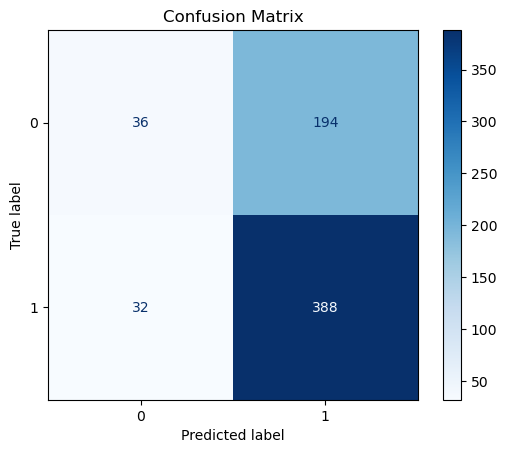

Optimization terminated successfully.
         Current function value: 0.626506
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   MHCA   No. Observations:                 3248
Model:                          Logit   Df Residuals:                     3242
Method:                           MLE   Df Model:                            5
Date:                Thu, 22 Aug 2024   Pseudo R-squ.:                 0.03631
Time:                        14:06:12   Log-Likelihood:                -2034.9
converged:                       True   LL-Null:                       -2111.6
Covariance Type:            nonrobust   LLR p-value:                 2.595e-31
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Age                     0.0045      0.002      1.809      0.070      -0.000       0.009
CT

In [758]:
# Train the model with best features and evaluate on the test dataset 
import copy
import statsmodels.api as sm

X_train_best = X_train[list(efs.best_feature_names_)]
X_test_best = X_test[list(efs.best_feature_names_)]

model_lr.fit(X_train_best, y_train)

# Predict y
y_pred_lr = model_lr.predict(X_test_best)
y_pred_proba_lr = model_lr.predict_proba(X_test_best)[:, 1]

# Calculate accuracy, AUC score and log loss
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.4f}")

auc_score = roc_auc_score(y_test, y_pred_proba_lr)
print(f"AUC Score: {auc_score:.4f}")

ll_score = log_loss(y_test, y_pred_proba_lr)
print(f"Log Loss: {ll_score:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_lr))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

if 'const' not in efs.best_feature_names_: 
    X_ols = X[list(efs.best_feature_names_)]
else: 
    X_ols = X[list(efs.best_feature_names_[1:])]
    X_ols = sm.add_constant(X_ols)

model = sm.Logit(y, X_ols.astype(float))  # Create a Logit model
result = model.fit() 
print(result.summary())

# Saving the model for deployement
model_mhca = copy.deepcopy(model_lr)
columns_mhca = copy.deepcopy(efs.best_feature_names_)

In [759]:
# Estimating calibration coefficient for MHCA for this dataset and general USA population
# Result is 0.708 / 0.228 = 3.105
# Note that MHCA prediciton for this dataset 0.6576 is close to the true value 0.645628

calibration_point = {
                     'Age': [39.0, wdf['Age'].median()],
                     'CTRY_Germany': [0, wdf.CTRY_Germany.mean()],
                     'CTRY_United Kingdom': [0, wdf['CTRY_United Kingdom'].mean()],
                     'CTRY_United States': [1.0, wdf['CTRY_United States'].mean()],
                     'Gender_Male': [0.495, wdf.Gender_Male.mean()],
                     'Gender_Other': [0.0036, wdf.Gender_Other.mean()]}
cal_df = pd.DataFrame(calibration_point)
# Predict probabilities
print('Best Logit model prediction of MHCA for USA general poluation:', model_lr.predict_proba(cal_df)[:, 1][0])
print('Best Logit model prediction of MHCA for our dataset:', model_lr.predict_proba(cal_df)[:, 1][1])

Best Logit model prediction of MHCA for USA general poluation: 0.7085708554571536
Best Logit model prediction of MHCA for our dataset: 0.6576671823817777


In [760]:
# To build XG Boost Classifier we first divide training set on small training and validation 
X_small_train, X_val, y_small_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

columns_to_drop = ['CTRY_United Kingdom']
X_small_train.drop(columns=columns_to_drop, inplace=True)
X_val.drop(columns=columns_to_drop, inplace=True) 

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.015, 0.02],
    'subsample': [0.75, 0.8, 0.85]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=3, verbose=1)

grid_search.fit(X_small_train, y_small_train)

# Get the best params and model
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Use permutations to get feature importance
feat_imp = permutation_importance(best_model, X_val, y_val, n_repeats=10, scoring='neg_log_loss')
pd.DataFrame({'features': X_val.columns, 'importances_mean': feat_imp['importances_mean'],
              'importances_std': feat_imp['importances_std']}).sort_values(by='importances_mean', ascending=False)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'learning_rate': 0.015, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}


,features,importances_mean,importances_std
4,CTRY_United States,0.010783,0.002427
5,Gender_Male,0.010575,0.005468
6,Gender_Other,0.007295,0.002363
1,Age,0.003967,0.001650
3,CTRY_Other,0.002898,0.001228
2,CTRY_Germany,0.000749,0.000341
0,const,0.000000,0.000000


Accuracy: 0.6508
AUC Score: 0.6651
Log Loss: 0.6166


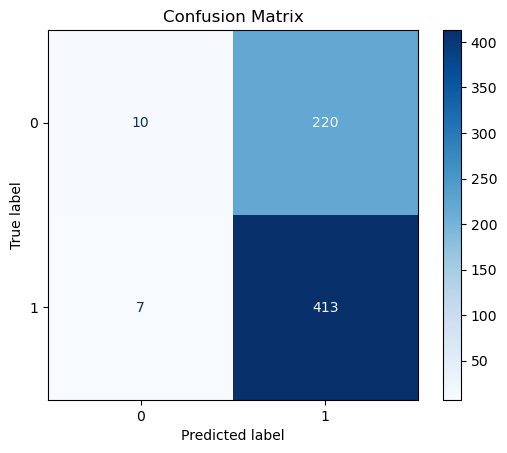

In [761]:
# Predict on the test set
y_pred_xg = best_model.predict(X_test.drop(columns=columns_to_drop))
y_pred_proba_xg = best_model.predict_proba(X_test.drop(columns=columns_to_drop))[:, 1]

# Evaluate the accuracy, AUC scrore and Log Loss
accuracy = accuracy_score(y_test, y_pred_xg)
print(f"Accuracy: {accuracy:.4f}")

auc_score = roc_auc_score(y_test, y_pred_proba_xg)
print(f"AUC Score: {auc_score:.4f}")

ll_score = log_loss(y_test, y_pred_proba_xg)
print(f"Log Loss: {ll_score:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_xg))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [762]:
# Checking calibration coefficient is we use XGBoost for predictions
# Result is 0.75195 / 0.228 = 3.30. Avergae of this coeff and 3.105 we got from Logit is 3.20. 
# Note that MHCA prediciton for this dataset 0.64620 is close to the true value 0.645628

calibration_point = {'const': [1.0, 1.0],
                     'Age': [39.0, wdf['Age'].median()],
                     'CTRY_Germany': [0, wdf['CTRY_Germany'].mean()],
                     'CTRY_Other': [0, wdf.CTRY_Other.mean()],
                     'CTRY_United States': [1.0, wdf['CTRY_United States'].mean()],
                     'Gender_Male': [0.495, wdf.Gender_Male.mean()],
                     'Gender_Other': [0.0036, wdf.Gender_Other.mean()]}
cal_df = pd.DataFrame(calibration_point)
# Predict probabilities
print('Best XGBoost model prediction of MHCA for USA general poluation:', best_model.predict_proba(cal_df)[:, 1][0])
print('Best XGBoost model prediction of MHCA for our dataset:', best_model.predict_proba(cal_df)[:, 1][1])

Best XGBoost model prediction of MHCA for USA general poluation: 0.75195074
Best XGBoost model prediction of MHCA for our dataset: 0.64620566


# <span style="font-size:0.7em;">Modeling MHCD</span>  

In [763]:
# To model MHCD we filter out people with MHC == 0
wdf = total_df[total_df.MHCA == 1].copy()
wdf = wdf.join(pd.get_dummies(total_df[['CTRY', 'Gender']], drop_first=True))
wdf = wdf.drop(columns=['Gender', 'CTRY', 'ProTE', 'ProNTE', 'year', 'ProD', 'ST', 'MHCA', 'Index']).dropna()
wdf.drop(columns=['INT1_1', 'INT1_2', 'INT1_4', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4'], inplace=True)
wdf = wdf.dropna()

X = wdf.drop(columns=['MHCD'])
y = wdf['MHCD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Select the features
selector = SelectKBest(chi2, k=2)
X_new = selector.fit_transform(X, y)

# print Chi²-statistics- and p-values per feature
tdf = pd.DataFrame({'features': X.columns.values, 'Scores': selector.scores_, 'p-values': selector.pvalues_}).sort_values(by='p-values')
tdf[tdf['p-values'] <= 0.05]

,features,Scores,p-values
2,CTRY_Other,23.912619,0.000001
4,CTRY_United States,14.904734,0.000113
1,CTRY_Germany,12.800384,0.000347
5,Gender_Male,12.072490,0.000512
6,Gender_Other,4.816525,0.028188


In [764]:
# Using EFS with Logistic Regression to get the best features to maximize accuracy
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Add a constant to the independent variables matrix (required for statsmodels)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Select the best features to max accuracy
model_lr = LogisticRegression(max_iter=10000)
efs = EFS(estimator=model_lr,       
         min_features=1,     
         max_features=8,     
         scoring='neg_log_loss', 
         cv=4)

efs = efs.fit(X_train, y_train)
print('Best features combination:', efs.best_feature_names_)

Features: 255/255

Best features combination: ('const', 'CTRY_Germany', 'CTRY_United States', 'Gender_Male', 'Gender_Other')


Accuracy: 0.6571
AUC Score: 0.5991
Log Loss: 0.6321


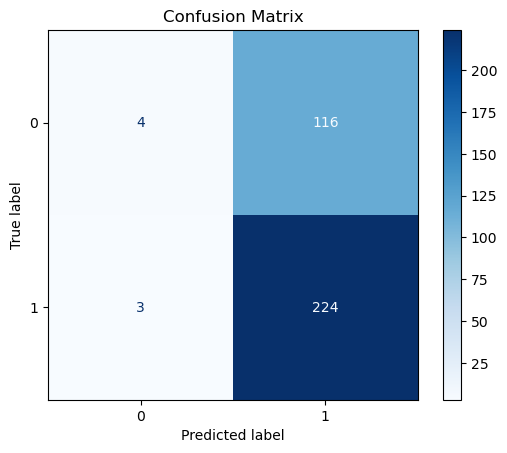

Optimization terminated successfully.
         Current function value: 0.621259
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   MHCD   No. Observations:                 1735
Model:                          Logit   Df Residuals:                     1730
Method:                           MLE   Df Model:                            4
Date:                Thu, 22 Aug 2024   Pseudo R-squ.:                 0.03599
Time:                        14:09:52   Log-Likelihood:                -1077.9
converged:                       True   LL-Null:                       -1118.1
Covariance Type:            nonrobust   LLR p-value:                 1.374e-16
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5321      0.131      4.058      0.000       0.275       0.789
CTRY_

In [765]:
# Train the model with best features and evaluate on the test dataset 
X_train_best = X_train[list(efs.best_feature_names_)]
X_test_best = X_test[list(efs.best_feature_names_)]

model_lr.fit(X_train_best, y_train)

# Predict y
y_pred_lr = model_lr.predict(X_test_best)
y_pred_proba_lr = model_lr.predict_proba(X_test_best)[:, 1]

# Calculate accuracy, AUC score and log loss
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.4f}")

auc_score = roc_auc_score(y_test, y_pred_proba_lr)
print(f"AUC Score: {auc_score:.4f}")

ll_score = log_loss(y_test, y_pred_proba_lr)
print(f"Log Loss: {ll_score:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_lr))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

if 'const' not in efs.best_feature_names_: 
    X_ols = X[list(efs.best_feature_names_)]
else: 
    X_ols = X[list(efs.best_feature_names_[1:])]
    X_ols = sm.add_constant(X_ols)

model = sm.Logit(y, X_ols.astype(float))  # Create a Logit model
result = model.fit() 
print(result.summary())



In [766]:
# To build XG Boost Classifier we first divide training set on small training and validation 
X_small_train, X_val, y_small_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

columns_to_drop = ['CTRY_Other', 'CTRY_Germany', 'Age', 'CTRY_United Kingdom']
X_small_train.drop(columns=columns_to_drop, inplace=True)
X_val.drop(columns=columns_to_drop, inplace=True) 

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.015, 0.02],
    'subsample': [0.55, 0.6, 0.65]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=3, verbose=1)

grid_search.fit(X_small_train, y_small_train)

# Get the best params and model
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Use permutations to get feature importance
feat_imp = permutation_importance(best_model, X_val, y_val, n_repeats=10, scoring='neg_log_loss')
pd.DataFrame({'features': X_val.columns, 'importances_mean': feat_imp['importances_mean'],
              'importances_std': feat_imp['importances_std']}).sort_values(by='importances_mean', ascending=False)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'learning_rate': 0.015, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.6}


,features,importances_mean,importances_std
1,CTRY_United States,0.018532,0.008683
2,Gender_Male,0.013819,0.004499
3,Gender_Other,0.001159,0.002809
0,const,0.000000,0.000000


Accuracy: 0.6484
AUC Score: 0.5990
Log Loss: 0.6308


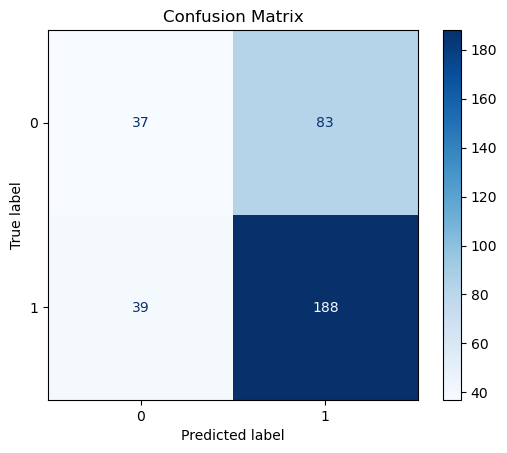

In [767]:
# Predict on the test set
y_pred_xg = best_model.predict(X_test.drop(columns=columns_to_drop))
y_pred_proba_xg = best_model.predict_proba(X_test.drop(columns=columns_to_drop))[:, 1]

# Evaluate the accuracy, AUC scrore and Log Loss
accuracy = accuracy_score(y_test, y_pred_xg)
print(f"Accuracy: {accuracy:.4f}")

auc_score = roc_auc_score(y_test, y_pred_proba_xg)
print(f"AUC Score: {auc_score:.4f}")

ll_score = log_loss(y_test, y_pred_proba_xg)
print(f"Log Loss: {ll_score:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_xg))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Saving the model for deployement
model_mhcd = copy.deepcopy(best_model)
columns_mhcd = copy.deepcopy(X_val.columns)

# 3.2. Modeling ST

In [768]:
# ST = 1 if the person sought tratment from MHC
# All INT features in the model

wdf = total_df[total_df.MHCA == 1].copy()
wdf = wdf.join(pd.get_dummies(total_df[['CTRY', 'Gender']], drop_first=True))
wdf = wdf.drop(columns=['Gender', 'CTRY', 'ProTE', 'ProNTE', 'year', 'ProD', 'MHCA', 'Index']).dropna()
wdf[['INT1_1', 'INT1_2', 'INT1_4', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4']] = \
    wdf[['INT1_1', 'INT1_2', 'INT1_4', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4']].astype(bool)
wdf = wdf.dropna()

X = wdf.drop(columns=['ST'])
y = wdf['ST'].astype(bool)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

selector = SelectKBest(chi2, k=2)
X_new = selector.fit_transform(X, y)

# print Chi²-statistics- and p-values per feature
tdf = pd.DataFrame({'features': X.columns.values, 'Scores': selector.scores_, 'p-values': selector.pvalues_}).sort_values(by='p-values')
tdf[tdf['p-values'] <= 0.05]

,features,Scores,p-values
0,MHCD,126.545321,2.336056e-29
11,CTRY_Other,48.418045,3.443845e-12
4,INT2_1,22.094434,2.595612e-06
13,CTRY_United States,21.134745,4.280955e-06
3,INT1_2,12.421862,4.243369e-04
14,Gender_Male,11.459161,7.114242e-04
7,INT3_3,11.131049,8.489455e-04
5,INT3_1,9.300416,2.291018e-03
2,INT1_1,8.848125,2.933901e-03
1,Age,7.663638,5.634477e-03


In [769]:
# Add a constant to the independent variables matrix (required for statsmodels)
X_train = sm.add_constant(X_train.astype(float))
X_test = sm.add_constant(X_test.astype(float))

# Build the logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print the summary of the model (includes coefficients, p-values, R-squared, etc.)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.377403
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                     ST   No. Observations:                 1388
Model:                          Logit   Df Residuals:                     1371
Method:                           MLE   Df Model:                           16
Date:                Thu, 22 Aug 2024   Pseudo R-squ.:                  0.2523
Time:                        14:15:40   Log-Likelihood:                -523.84
converged:                       True   LL-Null:                       -700.61
Covariance Type:            nonrobust   LLR p-value:                 1.874e-65
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.8645      0.638     -1.355      0.175      -2.115       0.386
MH

In [770]:
# Using EFS with Logistic Regression to get the best features to maximize accuracy
X_train_efs = X_train[['const', 'MHCD', 'INT3_3', 'CTRY_United States', 'Gender_Male', 'INT3_2', 'INT1_1', 'INT2_1']]

# Select the best features to max accuracy
model_lr = LogisticRegression(max_iter=10000)
efs = EFS(estimator=model_lr,       
         min_features=1,     
         max_features=8,     
         scoring='neg_log_loss', 
         cv=4)

efs = efs.fit(X_train_efs, y_train)
print('Best features combination:', efs.best_feature_names_)

Features: 255/255

Best features combination: ('MHCD', 'INT3_3', 'CTRY_United States', 'Gender_Male', 'INT3_2', 'INT1_1', 'INT2_1')


Accuracy: 0.8357
AUC Score: 0.8435
Log Loss: 0.3727


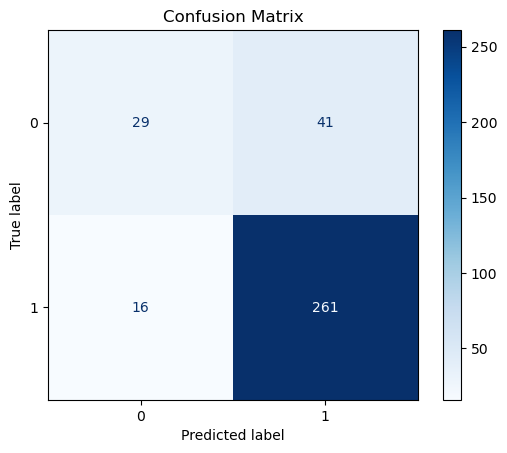

Optimization terminated successfully.
         Current function value: 0.378892
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                     ST   No. Observations:                 1735
Model:                          Logit   Df Residuals:                     1728
Method:                           MLE   Df Model:                            6
Date:                Thu, 22 Aug 2024   Pseudo R-squ.:                  0.2488
Time:                        14:15:54   Log-Likelihood:                -657.38
converged:                       True   LL-Null:                       -875.08
Covariance Type:            nonrobust   LLR p-value:                 6.752e-91
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
MHCD                   2.2927      0.145     15.831      0.000       2.009       2.577
INT3_

In [771]:
X_train_best = X_train[list(efs.best_feature_names_)]
X_test_best = X_test[list(efs.best_feature_names_)]

model_lr.fit(X_train_best, y_train)

# Predict y
y_pred_lr = model_lr.predict(X_test_best)
y_pred_proba_lr = model_lr.predict_proba(X_test_best)[:, 1]

# Calculate accuracy, AUC score and log loss
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy:.4f}")

auc_score = roc_auc_score(y_test, y_pred_proba_lr)
print(f"AUC Score: {auc_score:.4f}")

ll_score = log_loss(y_test, y_pred_proba_lr)
print(f"Log Loss: {ll_score:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_lr))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

if 'const' not in efs.best_feature_names_: 
    X_ols = X[list(efs.best_feature_names_)]
else: 
    X_ols = X[list(efs.best_feature_names_[1:])]
    X_ols = sm.add_constant(X_ols)

model = sm.Logit(y, X_ols.astype(float))  # Create a Logit model
result = model.fit() 
print(result.summary())

# Saving the model for deployement
model_st = copy.deepcopy(model_lr)
columns_st = copy.deepcopy(efs.best_feature_names_)

In [772]:
# To build XG Boost Classifier we first divide training set on small training and validation 
# Split the training set into validation and small training sets
X_small_train, X_val, y_small_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

columns_to_drop = ['CTRY_United Kingdom', 'INT3_1', 'INT3_4', 'Gender_Other']
X_small_train.drop(columns=columns_to_drop, inplace=True)
X_val.drop(columns=columns_to_drop, inplace=True) 

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [2, 3],
    'learning_rate': [0.015, 0.02, 0.25],
    'subsample': [0.55, 0.6, 0.65]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=3, verbose=1)

grid_search.fit(X_small_train, y_small_train)

# Get the best params and model
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Use permutations to get feature importance
feat_imp = permutation_importance(best_model, X_val, y_val, n_repeats=10, scoring='neg_log_loss')
pd.DataFrame({'features': X_val.columns, 'importances_mean': feat_imp['importances_mean'],
              'importances_std': feat_imp['importances_std']}).sort_values(by='importances_mean', ascending=False)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters found:  {'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 150, 'subsample': 0.65}


,features,importances_mean,importances_std
1,MHCD,0.178901,0.028428
7,INT3_3,0.007644,0.003905
11,CTRY_United States,0.006028,0.001375
10,CTRY_Other,0.003735,0.001002
5,INT2_1,0.003557,0.001517
12,Gender_Male,0.003308,0.002525
4,INT1_2,0.001762,0.001629
8,INT1_4,0.000631,0.001128
6,INT3_2,0.000545,0.000927
2,Age,0.000523,0.002743


Accuracy: 0.8213
AUC Score: 0.8397
Log Loss: 0.3784


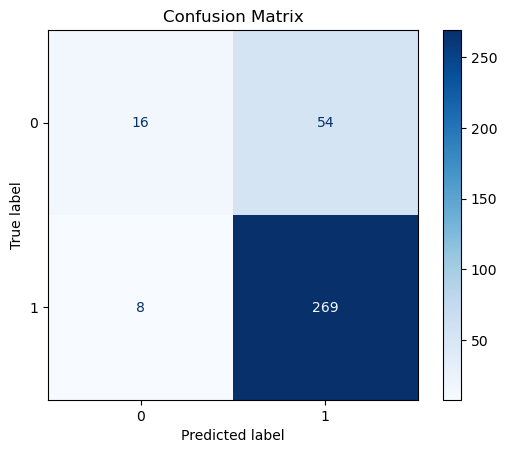

In [774]:
# Predict on the test set
y_pred_xg = best_model.predict(X_test.drop(columns=columns_to_drop))
y_pred_proba_xg = best_model.predict_proba(X_test.drop(columns=columns_to_drop))[:, 1]

# Evaluate the accuracy, AUC scrore and Log Loss
accuracy = accuracy_score(y_test, y_pred_xg)
print(f"Accuracy: {accuracy:.4f}")

auc_score = roc_auc_score(y_test, y_pred_proba_xg)
print(f"AUC Score: {auc_score:.4f}")

ll_score = log_loss(y_test, y_pred_proba_xg)
print(f"Log Loss: {ll_score:.4f}")

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix= confusion_matrix(y_test, y_pred_xg))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 3.3. Modeling treatment effect on productivity - ProD

# <span style="font-size:0.7em;">3.3.1. Productivity model for people without diagnosis</span> 

In [775]:
from sklearn.feature_selection import f_classif
from sklearn.metrics import mean_squared_error

wdf = total_df[total_df.MHCA == 1].copy()
wdf = wdf.join(pd.get_dummies(total_df[['CTRY', 'Gender']], drop_first=True))
wdf = wdf.drop(columns=['Gender', 'CTRY', 'ProTE', 'ProNTE', 'year', 'MHCA', 'Index']).dropna()
wdf = wdf.dropna()
wdf[['INT1_1', 'INT1_2', 'INT1_4', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4']] = \
    wdf[['INT1_1', 'INT1_2', 'INT1_4', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4']].astype(bool)

# We start with people without diagnosis and who sought treatment
wdf = wdf[(wdf.MHCD == 0) & (wdf.ST == 1)]
wdf.drop(columns=['MHCD', 'ST'], inplace=True)

X = wdf.drop(columns=['ProD'])
y = wdf['ProD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=f_classif, k=2)
selector.fit_transform(X, y)

# print ANOVA-statistics- and p-values per feature
tdf = pd.DataFrame({
    'features': X.columns,  
    'Scores': selector.scores_,
    'p-values': selector.pvalues_
})

significant_features = tdf.sort_values(by='p-values')
significant_features[significant_features['p-values'] <= 0.05]

,features,Scores,p-values
14,Gender_Other,3.1205,0.002211


In [776]:
from sklearn.linear_model import LinearRegression
# Add a constant to the independent variables matrix (required for statsmodels)
X_train = sm.add_constant(X_train.astype(float))
X_test = sm.add_constant(X_test.astype(float))

model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(model.summary())


Mean Squared Error: 0.00649193357065143
                            OLS Regression Results                            
Dep. Variable:                   ProD   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.203
Date:                Thu, 22 Aug 2024   Prob (F-statistic):              0.272
Time:                        14:16:21   Log-Likelihood:                 240.71
No. Observations:                 211   AIC:                            -449.4
Df Residuals:                     195   BIC:                            -395.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [777]:
# Select the best features to max accuracy
model_ols = LinearRegression()
efs = EFS(estimator=model_ols,       
         min_features=1,     
         max_features=7,     
         scoring='neg_mean_squared_error', 
         cv=4)

X_train_ols = X_train[['const', 'INT3_3', 'INT2_1', 'INT1_4', 'CTRY_United States', 'Gender_Male', 'Gender_Other']]
efs = efs.fit(X_train_ols, y_train)
print('Best features combination:', efs.best_feature_names_)

Features: 127/127

Best features combination: ('INT3_3', 'INT1_4')


In [778]:
# Train the model with best features and evaluate on the test dataset 
X_train_best = X_train[list(efs.best_feature_names_)]
X_test_best = X_test[list(efs.best_feature_names_)]

model_ols.fit(X_train_best, y_train)

# Predict y
y_pred_ols = model_ols.predict(X_test_best)
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred_ols)
print(f"Mean Squared Error: {mse}")

if 'const' not in efs.best_feature_names_: 
    X_ols = X[list(efs.best_feature_names_)]
else: 
    X_ols = X[list(efs.best_feature_names_[1:])]
    X_ols = sm.add_constant(X_ols)

result = sm.OLS(y, X_ols).fit()

print(result.summary())

# Saving the model for deployement
model_ProNDia = copy.deepcopy(model_ols)
columns_ProNDia = copy.deepcopy(efs.best_feature_names_)

Mean Squared Error: 0.006417231713006256
                                 OLS Regression Results                                
Dep. Variable:                   ProD   R-squared (uncentered):                   0.496
Model:                            OLS   Adj. R-squared (uncentered):              0.492
Method:                 Least Squares   F-statistic:                              129.0
Date:                Thu, 22 Aug 2024   Prob (F-statistic):                    1.00e-39
Time:                        14:16:23   Log-Likelihood:                          283.10
No. Observations:                 264   AIC:                                     -562.2
Df Residuals:                     262   BIC:                                     -555.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]


In [780]:
# To build XG Boost Classifier we first divide training set on small training and validation 
# Split the training set into validation and small training sets
X_small_train, X_val, y_small_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

columns_to_drop = ['CTRY_Germany', 'Age', 'Gender_Male', 'INT3_4', 'INT1_1', 'INT2_1', 'INT3_1', 
                   'CTRY_Other', 'INT3_2', 'INT1_2', 'INT3_3', 'Gender_Other']
X_small_train.drop(columns=columns_to_drop, inplace=True)
X_val.drop(columns=columns_to_drop, inplace=True) 

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.02, 0.025, 0.03],
    'subsample': [0.6, 0.65, 0.7]
}
# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1)

grid_search.fit(X_small_train, y_small_train)

# Get the best params and model
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Use permutations to get feature importance
feat_imp = permutation_importance(best_model, X_val, y_val, n_repeats=10, scoring='neg_mean_squared_error')
pd.DataFrame({'features': X_val.columns, 'importances_mean': feat_imp['importances_mean'],
              'importances_std': feat_imp['importances_std']}).sort_values(by='importances_mean', ascending=False)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'learning_rate': 0.025, 'max_depth': 3, 'n_estimators': 20, 'subsample': 0.65}


,features,importances_mean,importances_std
1,INT1_4,0.000322,0.000114
3,CTRY_United States,0.000210,0.000133
2,CTRY_United Kingdom,0.000084,0.000055
0,const,0.000000,0.000000


In [781]:
# Predict on the test set
y_pred_xg = best_model.predict(X_test.drop(columns=columns_to_drop))

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred_xg)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.0060938169607535515


# <span style="font-size:0.7em;">3.3.2. Productivity model for people with diagnosis</span>  

In [782]:
wdf = total_df[total_df.MHCA == 1].copy()
wdf = wdf.join(pd.get_dummies(total_df[['CTRY', 'Gender']], drop_first=True))
wdf = wdf.drop(columns=['Gender', 'CTRY', 'ProTE', 'ProNTE', 'year', 'MHCA', 'Index']).dropna()
wdf = wdf.dropna()
wdf[['INT1_1', 'INT1_2', 'INT1_4', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4']] = \
    wdf[['INT1_1', 'INT1_2', 'INT1_4', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4']].astype(bool)

# We start with people without diagnosis and who sought treatment
wdf = wdf[(wdf.MHCD == 1) & (wdf.ST == 1)]
wdf.drop(columns=['MHCD', 'ST'], inplace=True)

X = wdf.drop(columns=['ProD'])
y = wdf['ProD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=f_classif, k=2)
selector.fit_transform(X, y)

# print ANOVA-statistics- and p-values per feature
tdf = pd.DataFrame({
    'features': X.columns,  
    'Scores': selector.scores_,
    'p-values': selector.pvalues_
})

significant_features = tdf.sort_values(by='p-values')
significant_features[significant_features['p-values'] <= 0.05]

,features,Scores,p-values


In [783]:
# Add a constant to the independent variables matrix (required for statsmodels)
X_train = sm.add_constant(X_train.astype(float))
X_test = sm.add_constant(X_test.astype(float))

model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(model.summary())


Mean Squared Error: 0.005623281592407485
                            OLS Regression Results                            
Dep. Variable:                   ProD   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.368
Date:                Thu, 22 Aug 2024   Prob (F-statistic):              0.156
Time:                        14:16:41   Log-Likelihood:                 929.47
No. Observations:                 819   AIC:                            -1827.
Df Residuals:                     803   BIC:                            -1752.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [784]:
# Select the best features to max accuracy
model_ols = LinearRegression()
efs = EFS(estimator=model_ols,       
         min_features=1,     
         max_features=8,     
         scoring='neg_mean_squared_error', 
         cv=4)

X_train_ols = X_train[['Gender_Male', 'CTRY_United States', 'Gender_Other', 'INT3_1', 'INT3_3', 'INT1_4', 'CTRY_Germany', 'Age']]
efs = efs.fit(X_train_ols, y_train)
print('Best features combination:', efs.best_feature_names_)

Features: 255/255

Best features combination: ('CTRY_United States', 'INT3_3', 'INT1_4', 'CTRY_Germany', 'Age')


In [785]:
# Train the model with best features and evaluate on the test dataset 
X_train_best = X_train[list(efs.best_feature_names_)]
X_test_best = X_test[list(efs.best_feature_names_)]

model_ols.fit(X_train_best, y_train)

# Predict y
y_pred_ols = model_ols.predict(X_test_best)
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred_ols)
print(f"Mean Squared Error: {mse}")

if 'const' not in efs.best_feature_names_: 
    X_ols = X[list(efs.best_feature_names_)]
else: 
    X_ols = X[list(efs.best_feature_names_[1:])]
    X_ols = sm.add_constant(X_ols)

result = sm.OLS(y, X_ols.astype(float)).fit()
print(result.summary())

# Saving the model for deployement
model_ProDia = copy.deepcopy(model_ols)
columns_ProDia = copy.deepcopy(efs.best_feature_names_)

Mean Squared Error: 0.005563915666854951
                                 OLS Regression Results                                
Dep. Variable:                   ProD   R-squared (uncentered):                   0.695
Model:                            OLS   Adj. R-squared (uncentered):              0.694
Method:                 Least Squares   F-statistic:                              464.7
Date:                Thu, 22 Aug 2024   Prob (F-statistic):                   6.94e-260
Time:                        14:16:47   Log-Likelihood:                          1133.3
No. Observations:                1024   AIC:                                     -2257.
Df Residuals:                    1019   BIC:                                     -2232.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025     

In [787]:
# To build XG Boost Classifier we first divide training set on small training and validation 
# Split the training set into validation and small training sets
X_small_train, X_val, y_small_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

columns_to_drop = ['INT3_2', 'INT3_1', 'INT1_2', 'Gender_Other', 'CTRY_United States', 'CTRY_United Kingdom', 
                  'INT3_3', 'const', 'INT1_1', 'INT3_4']
X_small_train.drop(columns=columns_to_drop, inplace=True)
X_val.drop(columns=columns_to_drop, inplace=True) 

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [4, 5, 6],
    'max_depth': [2, 3],
    'learning_rate': [0.01, 0.015, 0.02],
    'subsample': [0.55, 0.6, 0.65]
}
# Set up the grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1)

grid_search.fit(X_small_train, y_small_train)

# Get the best params and model
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Use permutations to get feature importance
feat_imp = permutation_importance(best_model, X_val, y_val, n_repeats=10, scoring='neg_mean_squared_error')
pd.DataFrame({'features': X_val.columns, 'importances_mean': feat_imp['importances_mean'],
              'importances_std': feat_imp['importances_std']}).sort_values(by='importances_mean', ascending=False)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters found:  {'learning_rate': 0.02, 'max_depth': 2, 'n_estimators': 5, 'subsample': 0.6}


,features,importances_mean,importances_std
0,Age,0.000008,4.202047e-06
3,CTRY_Germany,0.000004,1.660260e-06
5,Gender_Male,0.000004,2.910591e-06
2,INT1_4,0.000003,1.469100e-06
1,INT2_1,0.000000,0.000000e+00
4,CTRY_Other,-0.000001,6.694090e-07


In [788]:
# Predict on the test set
y_pred_xg = best_model.predict(X_test.drop(columns=columns_to_drop))

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred_xg)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.005772100105336125


# 4. Deployment

In [789]:
# Estimating Case 1

total_df[['INT1_1', 'INT1_2', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4', 'INT1_4']] = \
        total_df[['INT1_1', 'INT1_2', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4', 'INT1_4']].astype(float)

MHCpro_dict = {'const': [1.0, 1.0],
              'Age': [33.0, 33.0],
              'CTRY_Germany': [1, 1],
              'CTRY_United Kingdom': [0, 0],
              'CTRY_United States': [0, 0],
              'CTRY_Other': [0, 0],
              'Gender_Male': [0.7, 0.7],
              'Gender_Other': [0.01, 0.01],
              'INT1_1': [total_df[total_df.CTRY == 'Germany']['INT1_1'].mean(), 0.9],
              'INT1_2': [total_df[total_df.CTRY == 'Germany']['INT1_2'].mean(), 0.9],
              'INT2_1': [total_df[total_df.CTRY == 'Germany']['INT2_1'].mean(), 0.9],
              'INT3_1': [total_df[total_df.CTRY == 'Germany']['INT3_1'].mean(), 0.5],
              'INT3_2': [total_df[total_df.CTRY == 'Germany']['INT3_2'].mean(), 0.67],
              'INT3_3': [total_df[total_df.CTRY == 'Germany']['INT3_3'].mean(), 0.5],
              'INT3_4': [total_df[total_df.CTRY == 'Germany']['INT3_4'].mean(), 0.7],
              'INT1_4': [total_df[total_df.CTRY == 'Germany']['INT1_4'].mean(), 0.8] 
             }
MHCpro_df = pd.DataFrame(MHCpro_dict)

result_df = pd.DataFrame(columns=['Start', 'End', 'Diff'], 
                         index=['MHC level', 'Diagnosis level', 'Seaking streatment with D', 'Seaking streatment without D',
                                'Productivity gain from T with D', 'Productivity gain from T without D', 'Total prod gain from T'])

# Predicting MHCA change
sdf = MHCpro_df[[*columns_mhca]]
result_df.at['MHC level', 'Start'] = model_mhca.predict_proba(sdf)[:, 1][0] / 3.2     # Corecting survey self-selection bias on 3.2
result_df.at['MHC level', 'End'] = model_mhca.predict_proba(sdf)[:, 1][1] / 3.2

# Predicting MHCD change
sdf = MHCpro_df[[*columns_mhcd]]
result_df.at['Diagnosis level', 'Start'] = model_mhcd.predict_proba(sdf)[:, 1][0] 
result_df.at['Diagnosis level', 'End'] = model_mhcd.predict_proba(sdf)[:, 1][1]

# Predicting ST change
# for people with diagnosis
MHCpro_df['MHCD'] = [1, 1]
sdf = MHCpro_df[[*columns_st]]
result_df.at['Seaking streatment with D', 'Start'] = model_st.predict_proba(sdf)[:, 1][0] 
result_df.at['Seaking streatment with D', 'End'] = model_st.predict_proba(sdf)[:, 1][1]

# for people without diagnosis
MHCpro_df['MHCD'] = [0, 0]
sdf = MHCpro_df[[*columns_st]]
result_df.at['Seaking streatment without D', 'Start'] = model_st.predict_proba(sdf)[:, 1][0] 
result_df.at['Seaking streatment without D', 'End'] = model_st.predict_proba(sdf)[:, 1][1]

# Predicting ProD
# for people with diagnosis
MHCpro_df['MHCD'] = [1, 1]
sdf = MHCpro_df[[*columns_ProDia]]
result_df.at['Productivity gain from T with D', 'Start'] = model_ProDia.predict(sdf)[0] 
result_df.at['Productivity gain from T with D', 'End'] = model_ProDia.predict(sdf)[1]

# for people without diagnosis
MHCpro_df['MHCD'] = [0, 0]
sdf = MHCpro_df[[*columns_ProNDia]]
result_df.at['Productivity gain from T without D', 'Start'] = model_ProNDia.predict(sdf)[0] 
result_df.at['Productivity gain from T without D', 'End'] = model_ProNDia.predict(sdf)[1]

# productivity gain for people with diagnosis
result_df.at['Total prod gain from T', 'Start'] =  result_df.at['MHC level', 'Start'] * \
            (result_df.at['Diagnosis level', 'Start'] * result_df.at['Seaking streatment with D', 'Start'] * \
             result_df.at['Productivity gain from T with D', 'Start'] + \
             (1 - result_df.at['Diagnosis level', 'Start']) * result_df.at['Seaking streatment without D', 'Start'] *\
              result_df.at['Productivity gain from T without D', 'Start'])
                                                           
result_df.at['Total prod gain from T', 'End'] =  result_df.at['MHC level', 'End'] * \
            (result_df.at['Diagnosis level', 'End'] * result_df.at['Seaking streatment with D', 'End'] * \
             result_df.at['Productivity gain from T with D', 'End'] + \
             (1 - result_df.at['Diagnosis level', 'End']) * result_df.at['Seaking streatment without D', 'End'] *\
              result_df.at['Productivity gain from T without D', 'End'])

result_df['Diff'] = result_df['End'] - result_df['Start']
result_df

,Start,End,Diff
MHC level,0.154428,0.154428,0.0
Diagnosis level,0.605661,0.605661,0.0
Seaking streatment with D,0.887863,0.922073,0.03421
Seaking streatment without D,0.447723,0.547824,0.100101
Productivity gain from T with D,0.154239,0.155908,0.001669
Productivity gain from T without D,0.075697,0.079482,0.003785
Total prod gain from T,0.014872,0.016097,0.001225


In [790]:
total_df[['INT1_1', 'INT1_2', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4', 'INT1_4']] = \
        total_df[['INT1_1', 'INT1_2', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4', 'INT1_4']].astype(float)
MHCpro_dict = {'const': [1.0, 1.0],
              'Age': [33.0, 33.0],
              'CTRY_Germany': [1, 1],
              'CTRY_United Kingdom': [0, 0],
              'CTRY_United States': [0, 0],
              'CTRY_Other': [0, 0],
              'Gender_Male': [0.7, 0.7],
              'Gender_Other': [0.01, 0.01],
              'INT1_1': [total_df[total_df.CTRY == 'Germany']['INT1_1'].mean(), 0.9],
              'INT1_2': [total_df[total_df.CTRY == 'Germany']['INT1_2'].mean(), 0.9],
              'INT2_1': [total_df[total_df.CTRY == 'Germany']['INT2_1'].mean(), 0.1],
              'INT3_1': [total_df[total_df.CTRY == 'Germany']['INT3_1'].mean(), 0.7],
              'INT3_2': [total_df[total_df.CTRY == 'Germany']['INT3_2'].mean(), 0.67],
              'INT3_3': [total_df[total_df.CTRY == 'Germany']['INT3_3'].mean(), 0.7],
              'INT3_4': [total_df[total_df.CTRY == 'Germany']['INT3_4'].mean(), 0.7],
              'INT1_4': [total_df[total_df.CTRY == 'Germany']['INT1_4'].mean(), 0.8] 
             }
MHCpro_df = pd.DataFrame(MHCpro_dict)

result_df = pd.DataFrame(columns=['Start', 'End', 'Diff'], 
                         index=['MHC level', 'Diagnosis level', 'Seaking streatment with D', 'Seaking streatment without D',
                                'Productivity gain from T with D', 'Productivity gain from T without D', 'Total prod gain from T'])

# Predicting MHCA change
sdf = MHCpro_df[[*columns_mhca]]
result_df.at['MHC level', 'Start'] = model_mhca.predict_proba(sdf)[:, 1][0] / 3.2     # Corecting survey self-selection bias on 3.2
result_df.at['MHC level', 'End'] = model_mhca.predict_proba(sdf)[:, 1][1] / 3.2

# Predicting MHCD change
sdf = MHCpro_df[[*columns_mhcd]]
result_df.at['Diagnosis level', 'Start'] = model_mhcd.predict_proba(sdf)[:, 1][0] 
result_df.at['Diagnosis level', 'End'] = model_mhcd.predict_proba(sdf)[:, 1][1]

# Predicting ST change
# for people with diagnosis
MHCpro_df['MHCD'] = [1, 1]
sdf = MHCpro_df[[*columns_st]]
result_df.at['Seaking streatment with D', 'Start'] = model_st.predict_proba(sdf)[:, 1][0] 
result_df.at['Seaking streatment with D', 'End'] = model_st.predict_proba(sdf)[:, 1][1]

# for people without diagnosis
MHCpro_df['MHCD'] = [0, 0]
sdf = MHCpro_df[[*columns_st]]
result_df.at['Seaking streatment without D', 'Start'] = model_st.predict_proba(sdf)[:, 1][0] 
result_df.at['Seaking streatment without D', 'End'] = model_st.predict_proba(sdf)[:, 1][1]

# Predicting ProD
# for people with diagnosis
MHCpro_df['MHCD'] = [1, 1]
sdf = MHCpro_df[[*columns_ProDia]]
result_df.at['Productivity gain from T with D', 'Start'] = model_ProDia.predict(sdf)[0] 
result_df.at['Productivity gain from T with D', 'End'] = model_ProDia.predict(sdf)[1]

# for people without diagnosis
MHCpro_df['MHCD'] = [0, 0]
sdf = MHCpro_df[[*columns_ProNDia]]
result_df.at['Productivity gain from T without D', 'Start'] = model_ProNDia.predict(sdf)[0] 
result_df.at['Productivity gain from T without D', 'End'] = model_ProNDia.predict(sdf)[1]

# productivity gain for people with diagnosis
result_df.at['Total prod gain from T', 'Start'] =  result_df.at['MHC level', 'Start'] * \
            (result_df.at['Diagnosis level', 'Start'] * result_df.at['Seaking streatment with D', 'Start'] * \
             result_df.at['Productivity gain from T with D', 'Start'] + \
             (1 - result_df.at['Diagnosis level', 'Start']) * result_df.at['Seaking streatment without D', 'Start'] *\
              result_df.at['Productivity gain from T without D', 'Start'])
                                                           
result_df.at['Total prod gain from T', 'End'] =  result_df.at['MHC level', 'End'] * \
            (result_df.at['Diagnosis level', 'End'] * result_df.at['Seaking streatment with D', 'End'] * \
             result_df.at['Productivity gain from T with D', 'End'] + \
             (1 - result_df.at['Diagnosis level', 'End']) * result_df.at['Seaking streatment without D', 'End'] *\
              result_df.at['Productivity gain from T without D', 'End'])

result_df['Diff'] = result_df['End'] - result_df['Start']
result_df

,Start,End,Diff
MHC level,0.154428,0.154428,0.0
Diagnosis level,0.605661,0.605661,0.0
Seaking streatment with D,0.887863,0.911834,0.02397
Seaking streatment without D,0.447723,0.514311,0.066588
Productivity gain from T with D,0.154239,0.158085,0.003845
Productivity gain from T without D,0.075697,0.08598,0.010283
Total prod gain from T,0.014872,0.016175,0.001303


In [721]:
total_df[['INT1_1', 'INT1_2', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4', 'INT1_4']] = \
        total_df[['INT1_1', 'INT1_2', 'INT2_1', 'INT3_1', 'INT3_2', 'INT3_3', 'INT3_4', 'INT1_4']].astype(float)
MHCpro_dict = {'const': [1.0, 1.0],
              'Age': [33.0, 33.0],
              'CTRY_Germany': [1, 1],
              'CTRY_United Kingdom': [0, 0],
              'CTRY_United States': [0, 0],
              'CTRY_Other': [0, 0],
              'Gender_Male': [0.7, 0.7],
              'Gender_Other': [0.01, 0.01],
              'INT1_1': [total_df[total_df.CTRY == 'Germany']['INT1_1'].mean(), 0.0],
              'INT1_2': [total_df[total_df.CTRY == 'Germany']['INT1_2'].mean(), 0.9],
              'INT2_1': [total_df[total_df.CTRY == 'Germany']['INT2_1'].mean(), 0.1],
              'INT3_1': [total_df[total_df.CTRY == 'Germany']['INT3_1'].mean(), 0.7],
              'INT3_2': [total_df[total_df.CTRY == 'Germany']['INT3_2'].mean(), 0.67],
              'INT3_3': [total_df[total_df.CTRY == 'Germany']['INT3_3'].mean(), 0.7],
              'INT3_4': [total_df[total_df.CTRY == 'Germany']['INT3_4'].mean(), 0.7],
              'INT1_4': [total_df[total_df.CTRY == 'Germany']['INT1_4'].mean(), 0.8] 
             }
MHCpro_df = pd.DataFrame(MHCpro_dict)

result_df = pd.DataFrame(columns=['Start', 'End', 'Diff'], 
                         index=['MHC level', 'Diagnosis level', 'Seaking streatment with D', 'Seaking streatment without D',
                                'Productivity gain from T with D', 'Productivity gain from T without D', 'Total prod gain from T'])

# Predicting MHCA change
sdf = MHCpro_df[[*columns_mhca]]
result_df.at['MHC level', 'Start'] = model_mhca.predict_proba(sdf)[:, 1][0] / 3.2     # Corecting survey self-selection bias on 3.2
result_df.at['MHC level', 'End'] = model_mhca.predict_proba(sdf)[:, 1][1] / 3.2

# Predicting MHCD change
sdf = MHCpro_df[[*columns_mhcd]]
result_df.at['Diagnosis level', 'Start'] = model_mhcd.predict_proba(sdf)[:, 1][0] 
result_df.at['Diagnosis level', 'End'] = model_mhcd.predict_proba(sdf)[:, 1][1]

# Predicting ST change
# for people with diagnosis
MHCpro_df['MHCD'] = [1, 1]
sdf = MHCpro_df[[*columns_st]]
result_df.at['Seaking streatment with D', 'Start'] = model_st.predict_proba(sdf)[:, 1][0] 
result_df.at['Seaking streatment with D', 'End'] = model_st.predict_proba(sdf)[:, 1][1]

# for people without diagnosis
MHCpro_df['MHCD'] = [0, 0]
sdf = MHCpro_df[[*columns_st]]
result_df.at['Seaking streatment without D', 'Start'] = model_st.predict_proba(sdf)[:, 1][0] 
result_df.at['Seaking streatment without D', 'End'] = model_st.predict_proba(sdf)[:, 1][1]

# Predicting ProD
# for people with diagnosis
MHCpro_df['MHCD'] = [1, 1]
sdf = MHCpro_df[[*columns_ProDia]]
result_df.at['Productivity gain from T with D', 'Start'] = model_ProDia.predict(sdf)[0] 
result_df.at['Productivity gain from T with D', 'End'] = model_ProDia.predict(sdf)[1]

# for people without diagnosis
MHCpro_df['MHCD'] = [0, 0]
sdf = MHCpro_df[[*columns_ProNDia]]
result_df.at['Productivity gain from T without D', 'Start'] = model_ProNDia.predict(sdf)[0] 
result_df.at['Productivity gain from T without D', 'End'] = model_ProNDia.predict(sdf)[1]

# productivity gain for people with diagnosis
result_df.at['Total prod gain from T', 'Start'] =  result_df.at['MHC level', 'Start'] * \
            (result_df.at['Diagnosis level', 'Start'] * result_df.at['Seaking streatment with D', 'Start'] * \
             result_df.at['Productivity gain from T with D', 'Start'] + \
             (1 - result_df.at['Diagnosis level', 'Start']) * result_df.at['Seaking streatment without D', 'Start'] *\
              result_df.at['Productivity gain from T without D', 'Start'])
                                                           
result_df.at['Total prod gain from T', 'End'] =  result_df.at['MHC level', 'End'] * \
            (result_df.at['Diagnosis level', 'End'] * result_df.at['Seaking streatment with D', 'End'] * \
             result_df.at['Productivity gain from T with D', 'End'] + \
             (1 - result_df.at['Diagnosis level', 'End']) * result_df.at['Seaking streatment without D', 'End'] *\
              result_df.at['Productivity gain from T without D', 'End'])

result_df['Diff'] = result_df['End'] - result_df['Start']
result_df

,Start,End,Diff
MHC level,0.154176,0.154176,0.0
Diagnosis level,0.600659,0.600659,0.0
Seaking streatment with D,0.877894,0.880324,0.00243
Seaking streatment without D,0.421881,0.427468,0.005587
Productivity gain from T with D,0.154239,0.158085,0.003845
Productivity gain from T without D,0.075697,0.08598,0.010283
Total prod gain from T,0.014506,0.015151,0.000645
